# Machine Learning Group Project - Online News Popularity

## Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
from sklearn import linear_model
from sklearn.datasets import make_regression

from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV,ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib import pyplot
import seaborn as sns

from sklearn.svm import LinearSVC

import warnings
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import ShuffleSplit

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, adjusted_mutual_info_score

In [3]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
with open("OnlineNewsPopularity.names") as f:
    print(f.read())

1. Title: Online News Popularity

2. Source Information
    -- Creators: Kelwin Fernandes (kafc ‘@’ inesctec.pt, kelwinfc ’@’ gmail.com),
                 Pedro Vinagre (pedro.vinagre.sousa ’@’ gmail.com) and
                 Pedro Sernadela
   -- Donor: Kelwin Fernandes (kafc ’@’ inesctec.pt, kelwinfc '@' gmail.com)
   -- Date: May, 2015

3. Past Usage:
    1. K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision
       Support System for Predicting the Popularity of Online News. Proceedings
       of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence,
       September, Coimbra, Portugal.

       -- Results: 
          -- Binary classification as popular vs unpopular using a decision
             threshold of 1400 social interactions.
          -- Experiments with different models: Random Forest (best model),
             Adaboost, SVM, KNN and Naïve Bayes.
          -- Recorded 67% of accuracy and 0.73 of AUC.
    - Predicted attribute: online ne

# Data Preprocessing

In [5]:
#Read csv files
df = pd.read_csv("OnlineNewsPopularity.csv")

In [6]:
#drop the non-predictive attributes
df.drop(labels=['url', ' timedelta'], axis = 1, inplace=True) 

In [7]:
# find highly correlated features
cor_matrix = df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
print(to_drop)

[' n_non_stop_words', ' n_non_stop_unique_tokens', ' kw_avg_min', ' kw_max_max', ' self_reference_avg_sharess']


In [8]:
# drop out highly correlated features
df = df.drop([' n_non_stop_words', ' n_non_stop_unique_tokens', ' kw_avg_min', ' kw_max_max', ' self_reference_avg_sharess'], axis=1)

In [9]:
# find a criteria for the shares
share_df = df[' shares']
df[' shares'].describe()

count     39644.000000
mean       3395.380184
std       11626.950749
min           1.000000
25%         946.000000
50%        1400.000000
75%        2800.000000
max      843300.000000
Name:  shares, dtype: float64

In [10]:
# add class label
share_data = df[' shares']

share_label = list()
for share in share_data:
    if share <= 1400:
        share_label.append('Unpopular')
    else:
        share_label.append('Popular')
df = pd.concat([df, pd.DataFrame(share_label, columns=['popularity'])], axis=1)

In [11]:
df.shape

(39644, 55)

In [12]:
df.columns

Index([' n_tokens_title', ' n_tokens_content', ' n_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_min_max',
       ' kw_avg_max', ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg',
       ' self_reference_min_shares', ' self_reference_max_shares',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sentiment_polarity', ' global_rate_positive_words',
       ' global_rate_negative_words', ' rate_positive_words',
       ' rate_negative_words', ' avg

In [13]:
print(df.isnull().sum()) # Check if there are any missing values

 n_tokens_title                   0
 n_tokens_content                 0
 n_unique_tokens                  0
 num_hrefs                        0
 num_self_hrefs                   0
 num_imgs                         0
 num_videos                       0
 average_token_length             0
 num_keywords                     0
 data_channel_is_lifestyle        0
 data_channel_is_entertainment    0
 data_channel_is_bus              0
 data_channel_is_socmed           0
 data_channel_is_tech             0
 data_channel_is_world            0
 kw_min_min                       0
 kw_max_min                       0
 kw_min_max                       0
 kw_avg_max                       0
 kw_min_avg                       0
 kw_max_avg                       0
 kw_avg_avg                       0
 self_reference_min_shares        0
 self_reference_max_shares        0
 weekday_is_monday                0
 weekday_is_tuesday               0
 weekday_is_wednesday             0
 weekday_is_thursday        

In [14]:
X = df.drop([' shares','popularity'],axis = 1)
y = df['popularity']

In [15]:
X.shape

(39644, 53)

In [16]:
y.shape

(39644,)

In [17]:
df.dtypes # Check the data types of atributes

 n_tokens_title                   float64
 n_tokens_content                 float64
 n_unique_tokens                  float64
 num_hrefs                        float64
 num_self_hrefs                   float64
 num_imgs                         float64
 num_videos                       float64
 average_token_length             float64
 num_keywords                     float64
 data_channel_is_lifestyle        float64
 data_channel_is_entertainment    float64
 data_channel_is_bus              float64
 data_channel_is_socmed           float64
 data_channel_is_tech             float64
 data_channel_is_world            float64
 kw_min_min                       float64
 kw_max_min                       float64
 kw_min_max                       float64
 kw_avg_max                       float64
 kw_min_avg                       float64
 kw_max_avg                       float64
 kw_avg_avg                       float64
 self_reference_min_shares        float64
 self_reference_max_shares        

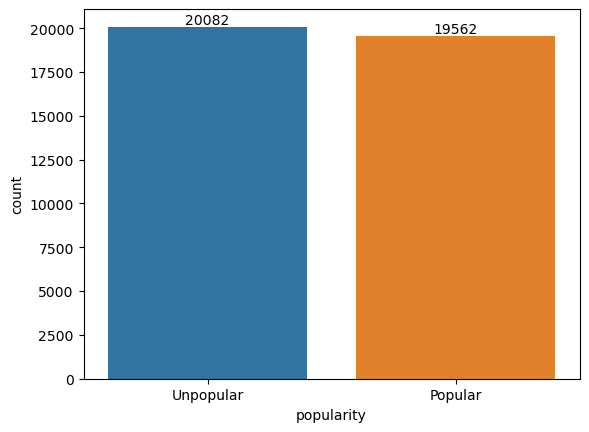

In [18]:
p = sns.countplot(df["popularity"])
for container in p.containers:
    p.bar_label(container)

# Features Analysis

In [19]:
# Divide features into 9 categories based on their description
word_features = [' n_tokens_title', 
                 ' n_tokens_content', 
                 ' n_unique_tokens',  
                 ' average_token_length']

media_features = [' num_imgs', ' num_videos']

day_features = [' weekday_is_monday', 
                     ' weekday_is_tuesday', 
                     ' weekday_is_wednesday',
                     ' weekday_is_thursday',
                     ' weekday_is_friday',
                     ' weekday_is_saturday',
                     ' weekday_is_sunday',
                     ' is_weekend']

channel_features = [' data_channel_is_lifestyle', ' data_channel_is_entertainment', 
                    ' data_channel_is_bus', ' data_channel_is_socmed', 
                    ' data_channel_is_tech', ' data_channel_is_world']

keyword_features = [' kw_min_min', ' kw_max_min', 
                    ' kw_min_max', ' kw_avg_max', 
                    ' kw_min_avg', ' kw_max_avg', ' kw_avg_avg',
                    ' num_keywords']


reference_features = [' num_hrefs',
                      ' num_self_hrefs',
                      ' self_reference_min_shares',
                      ' self_reference_max_shares']

topic_features = [' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04']

subjectivity_features = [' global_subjectivity', ' title_subjectivity', ' abs_title_subjectivity']

sentiment_features = [' global_sentiment_polarity', ' global_rate_positive_words',
                      ' global_rate_negative_words', ' rate_positive_words',
                      ' rate_negative_words', ' avg_positive_polarity',
                      ' min_positive_polarity', ' max_positive_polarity',
                      ' avg_negative_polarity', ' min_negative_polarity',
                      ' max_negative_polarity', ' title_sentiment_polarity',
                      ' abs_title_sentiment_polarity']

In [20]:
# Merge the weekdays columns
weekdays=df[day_features]
weekdays_merge=[]
for r in list(range(weekdays.shape[0])):
    for c in list(range(weekdays.shape[1])):
        if ((c==0) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Monday')
        elif ((c==1) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Tuesday')
        elif ((c==2) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Wednesday')
        elif ((c==3) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Thursday')
        elif ((c==4) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Friday')
        elif ((c==5) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Saturday') 
        elif ((c==6) and (weekdays.iloc[r,c])==1):
            weekdays_merge.append('Sunday')
            
# Merge the data channel columns

channel=df[channel_features]
#logic to merge data channel
channel_merge=[]
for r in list(range(channel.shape[0])):
    if (((channel.iloc[r,0])==0) and ((channel.iloc[r,1])==0) and ((channel.iloc[r,2])==0) and ((channel.iloc[r,3])==0) and ((channel.iloc[r,4])==0) and ((channel.iloc[r,5])==0)):
        channel_merge.append('Others') # put 0 values to Others category
    for c in list(range(channel.shape[1])):
        if ((c==0) and (channel.iloc[r,c])==1):
            channel_merge.append('Lifestyle')
        elif ((c==1) and (channel.iloc[r,c])==1):
            channel_merge.append('Entertainment')
        elif ((c==2) and (channel.iloc[r,c])==1):
            channel_merge.append('Business')
        elif ((c==3) and (channel.iloc[r,c])==1):
            channel_merge.append('Social Media')
        elif ((c==4) and (channel.iloc[r,c])==1):
            channel_merge.append('Tech')
        elif ((c==5) and (channel.iloc[r,c])==1):
            channel_merge.append('World')

In [21]:
df2 = df.copy(deep=True) # creat a copy of df

In [22]:
###########
scaler = MinMaxScaler()
df2 = df.drop('popularity', axis=1)
df2_scaled = scaler.fit_transform(df2.to_numpy())
df2_scaled = pd.DataFrame(df2_scaled, columns=list(df.columns)[:-1])

df2_scaled = pd.concat([df2_scaled,df['popularity']], axis=1) # add the target

print("Scaled Dataset Using MinMaxScaler")
df2_scaled.head()

Scaled Dataset Using MinMaxScaler


,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity
0,0.476190,0.025844,0.000947,0.013158,0.017241,0.007812,0.0,0.582024,0.444444,0.0,...,0.7,0.650000,0.400,0.800000,0.500000,0.406250,0.000000,0.187500,0.000702,Unpopular
1,0.333333,0.030092,0.000863,0.009868,0.008621,0.007812,0.0,0.611043,0.333333,0.0,...,0.7,0.881250,0.875,0.900000,0.000000,0.500000,1.000000,0.000000,0.000842,Unpopular
2,0.333333,0.024900,0.000820,0.009868,0.008621,0.007812,0.0,0.546334,0.555556,0.0,...,1.0,0.533333,0.200,0.866667,0.000000,0.500000,1.000000,0.000000,0.001778,Popular
3,0.333333,0.062662,0.000719,0.029605,0.000000,0.007812,0.0,0.547768,0.666667,0.0,...,0.8,0.630303,0.400,0.833333,0.000000,0.500000,1.000000,0.000000,0.001422,Unpopular
4,0.523810,0.126505,0.000593,0.062500,0.163793,0.156250,0.0,0.582331,0.666667,0.0,...,1.0,0.779808,0.500,0.950000,0.454545,0.568182,0.090909,0.136364,0.000598,Unpopular


In [23]:
# add new columns on df2_scaled
df2_scaled.insert(loc=11, column='days', value=weekdays_merge)
df2_scaled.insert(loc=12, column='data_channel', value=channel_merge)

In [24]:
# define a function to visualize relationship between selected features and popularity
def show_barplots(df,features_list,target):
    cnt=1
    plt.figure(figsize=(20,6))
    for i in features_list:
        plt.subplot(1,len(features_list),cnt) 
        cnt+=1
        sns.barplot(df[target],df[i])
        plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

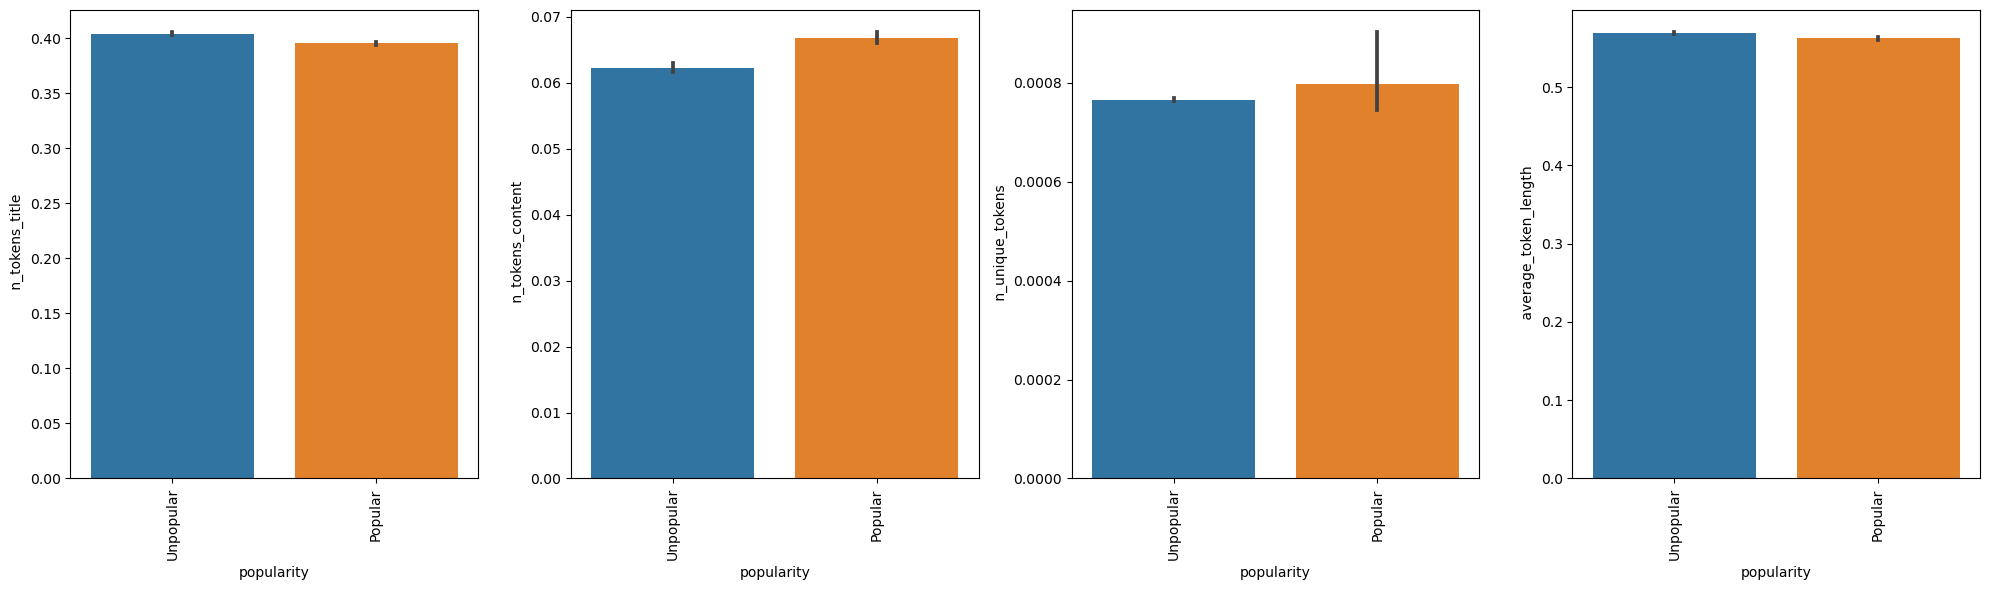

In [25]:
show_barplots(df2_scaled,word_features,'popularity') # Comparing word features of 2 class

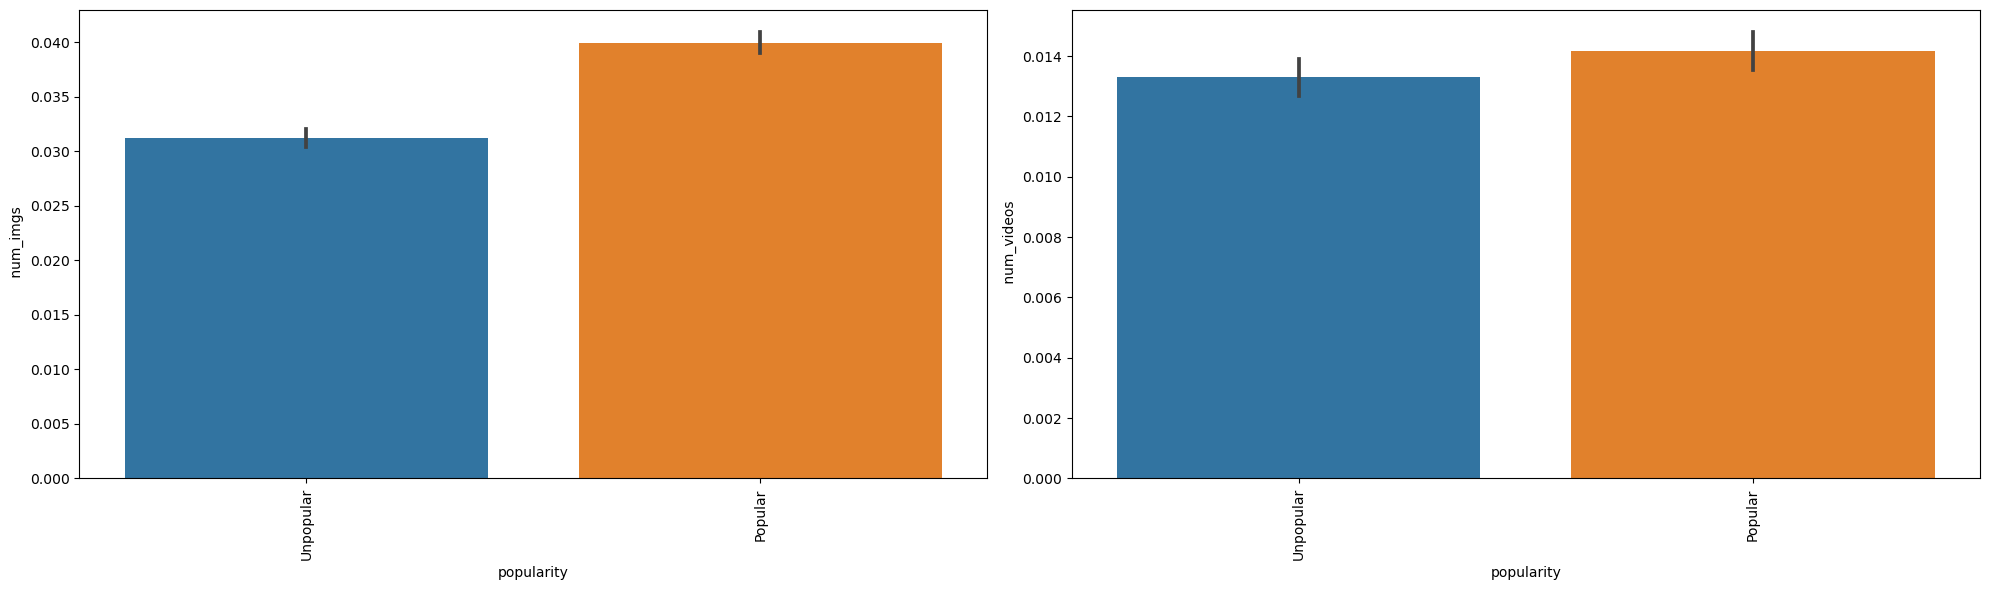

In [26]:
show_barplots(df2_scaled,media_features,'popularity') # Comparing media features of 2 class

In [27]:
df2_scaled.days.value_counts() # count article published by days

Wednesday    7435
Tuesday      7390
Thursday     7267
Monday       6661
Friday       5701
Sunday       2737
Saturday     2453
Name: days, dtype: int64

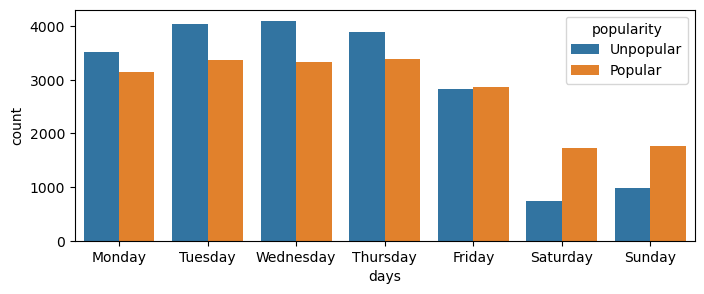

In [28]:
plt.figure(figsize=(8,3))
sns.countplot(df2_scaled.days,hue=df2_scaled['popularity']) # Comparing published days features of 2 class
plt.show()

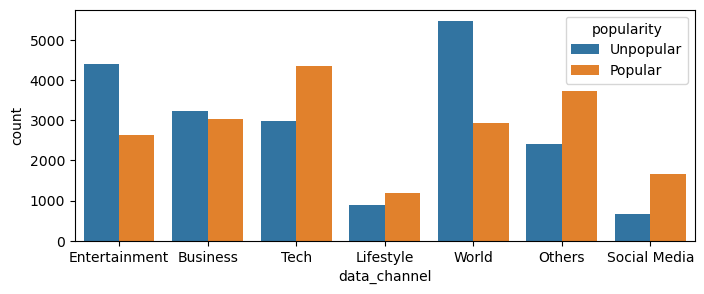

In [29]:
plt.figure(figsize=(8,3))
sns.countplot(df2_scaled.data_channel,hue=df2_scaled['popularity']) # Comparing data channel features of 2 class
plt.show()

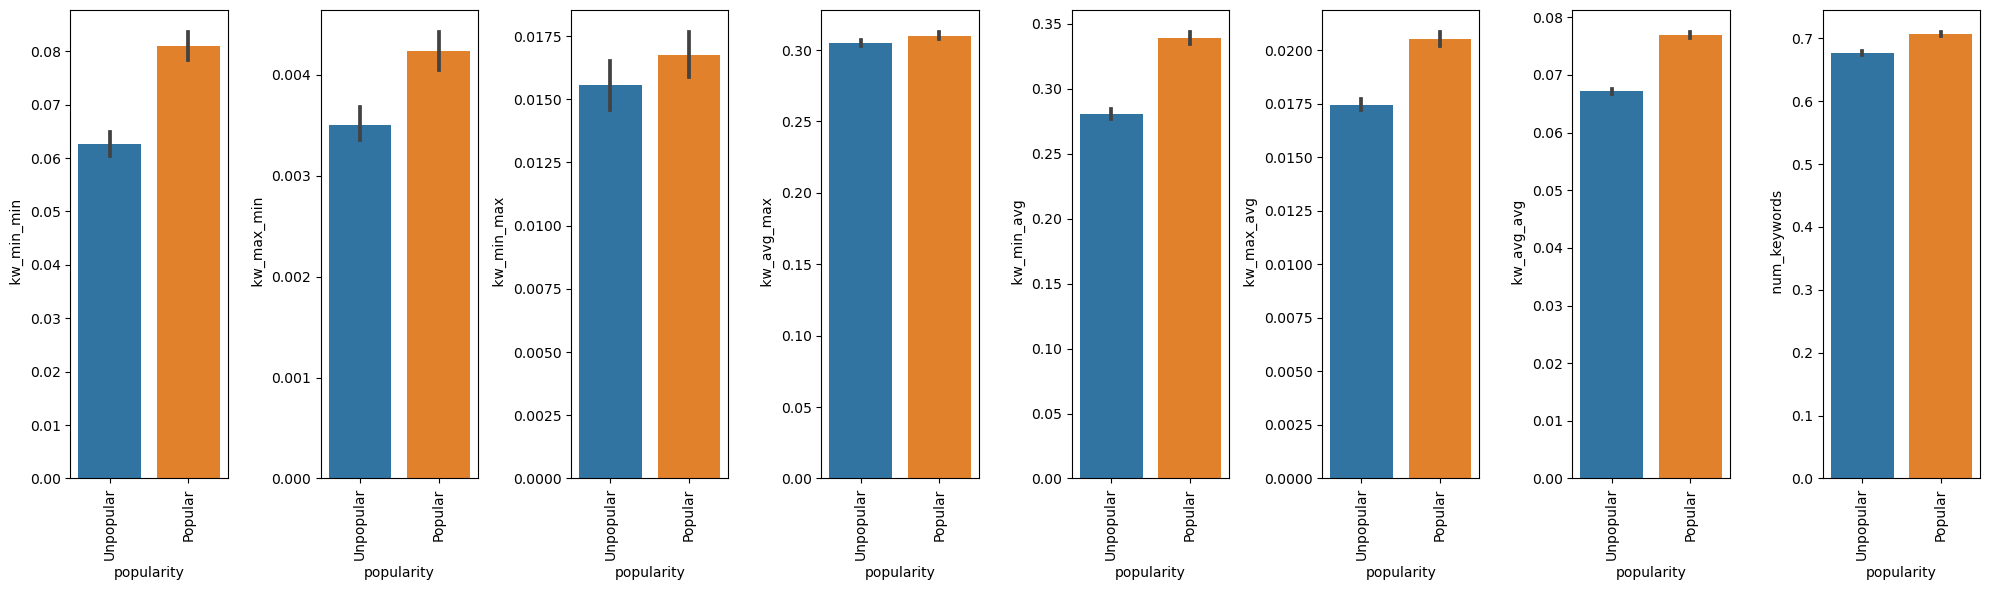

In [30]:
show_barplots(df2_scaled,keyword_features,'popularity') # Comparing keyword features of 2 class

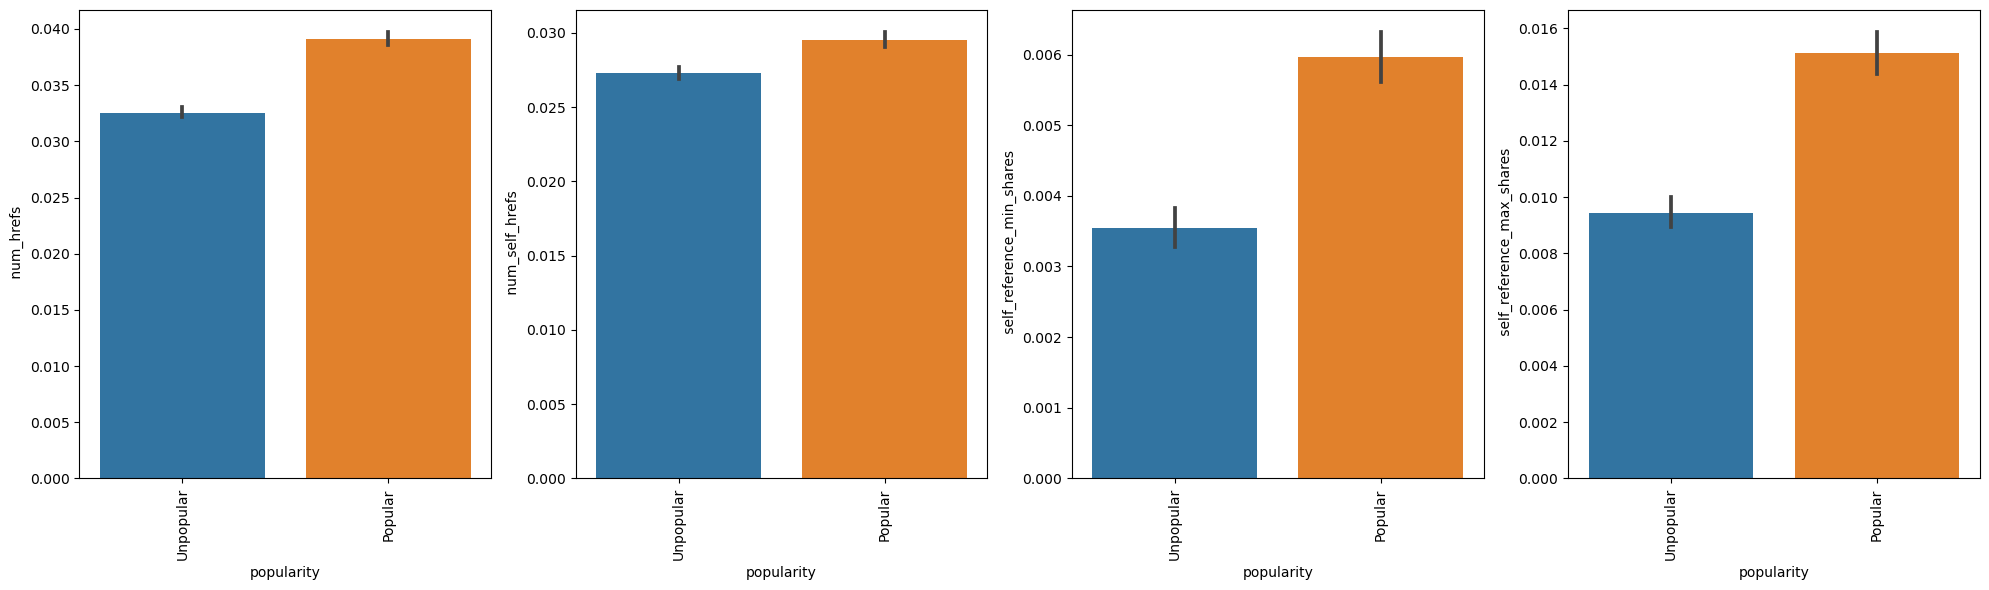

In [31]:
show_barplots(df2_scaled,reference_features,'popularity')  # Comparing reference features of 2 class

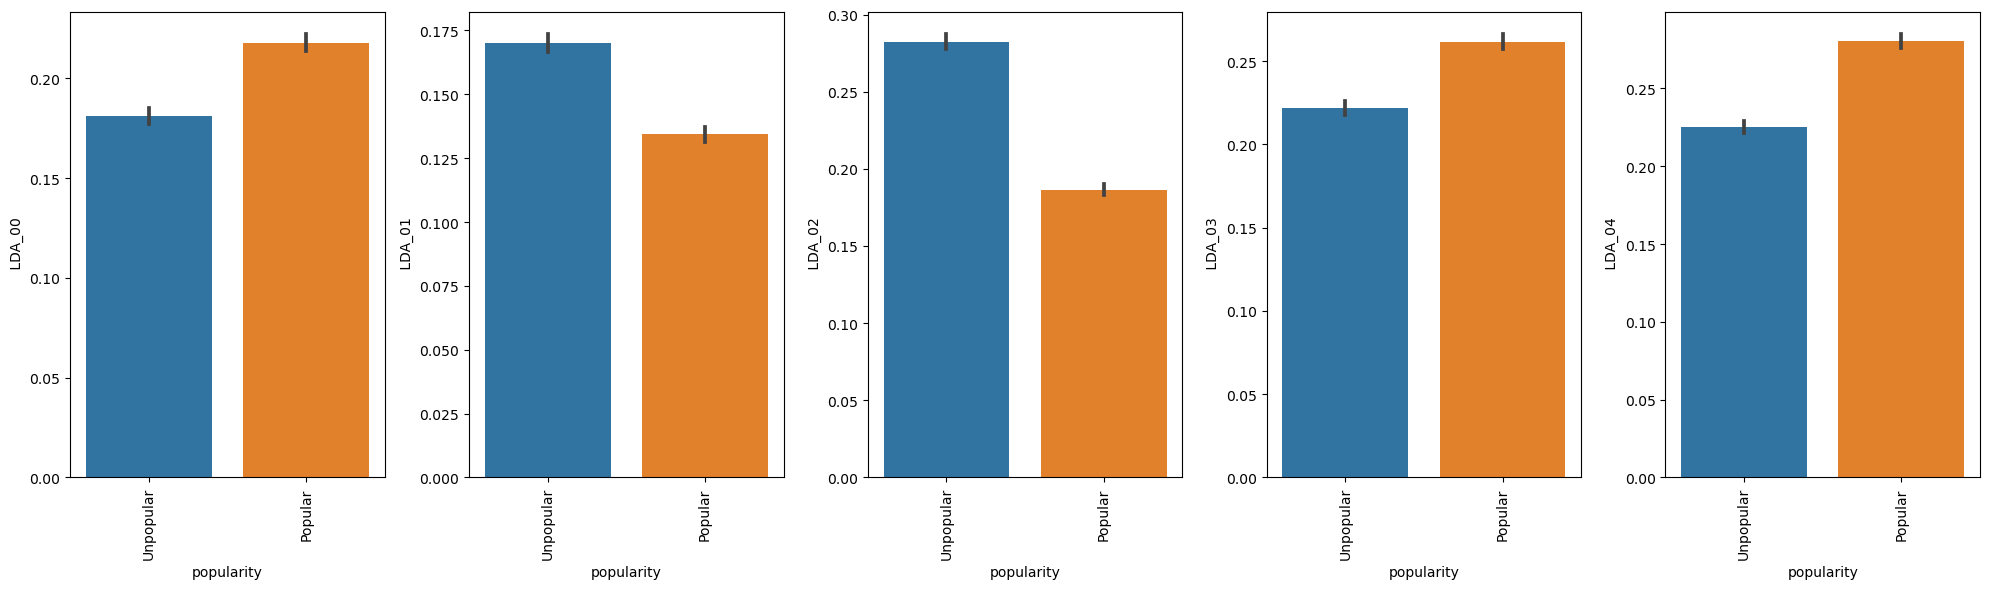

In [32]:
show_barplots(df2_scaled,topic_features,'popularity') # Comparing topic features of 2 class

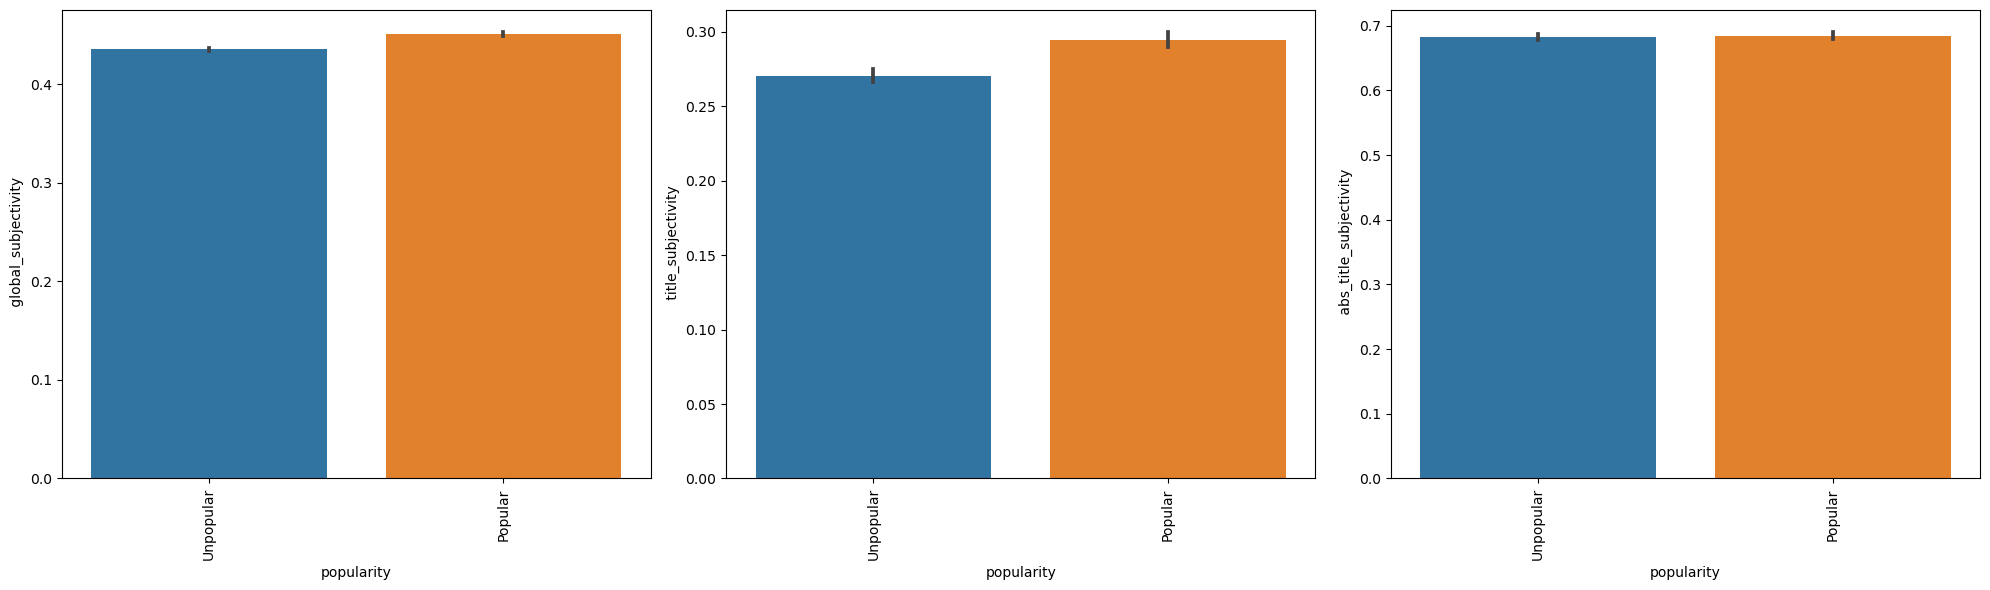

In [33]:
show_barplots(df2_scaled,subjectivity_features,'popularity') # Comparing subjectivity features of 2 class

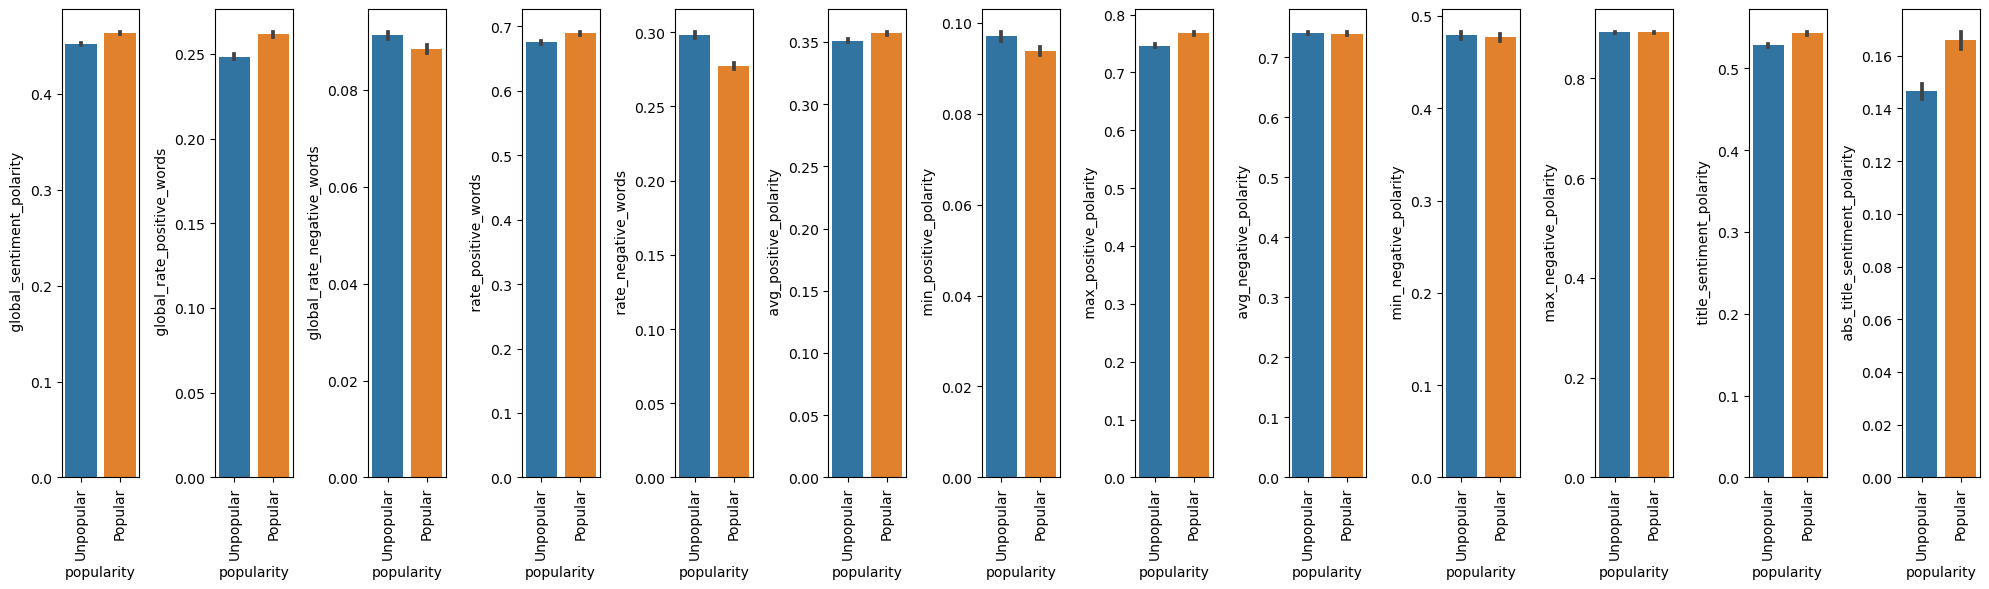

In [34]:
show_barplots(df2_scaled,sentiment_features,'popularity') # Comparing sentiment features of 2 class

In [35]:
# Show summary statistics
df.describe()

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,10.398749,546.514731,0.548216,10.883690,3.293638,4.544143,1.249874,4.548239,7.223767,0.052946,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,2.114037,471.107508,3.520708,11.332017,3.855141,8.309434,4.107855,0.844406,1.909130,0.223929,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,9.000000,246.000000,0.470870,4.000000,1.000000,1.000000,0.000000,4.478404,6.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,10.000000,409.000000,0.539226,8.000000,3.000000,1.000000,0.000000,4.664082,7.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,12.000000,716.000000,0.608696,14.000000,4.000000,4.000000,1.000000,4.854839,9.000000,0.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,23.000000,8474.000000,701.000000,304.000000,116.000000,128.000000,91.000000,8.041534,10.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


array([[<AxesSubplot:title={'center':' n_tokens_title'}>,
        <AxesSubplot:title={'center':' n_tokens_content'}>,
        <AxesSubplot:title={'center':' n_unique_tokens'}>,
        <AxesSubplot:title={'center':' num_hrefs'}>,
        <AxesSubplot:title={'center':' num_self_hrefs'}>,
        <AxesSubplot:title={'center':' num_imgs'}>,
        <AxesSubplot:title={'center':' num_videos'}>],
       [<AxesSubplot:title={'center':' average_token_length'}>,
        <AxesSubplot:title={'center':' num_keywords'}>,
        <AxesSubplot:title={'center':' data_channel_is_lifestyle'}>,
        <AxesSubplot:title={'center':' data_channel_is_entertainment'}>,
        <AxesSubplot:title={'center':' data_channel_is_bus'}>,
        <AxesSubplot:title={'center':' data_channel_is_socmed'}>,
        <AxesSubplot:title={'center':' data_channel_is_tech'}>],
       [<AxesSubplot:title={'center':' data_channel_is_world'}>,
        <AxesSubplot:title={'center':' kw_min_min'}>,
        <AxesSubplot:title={'c

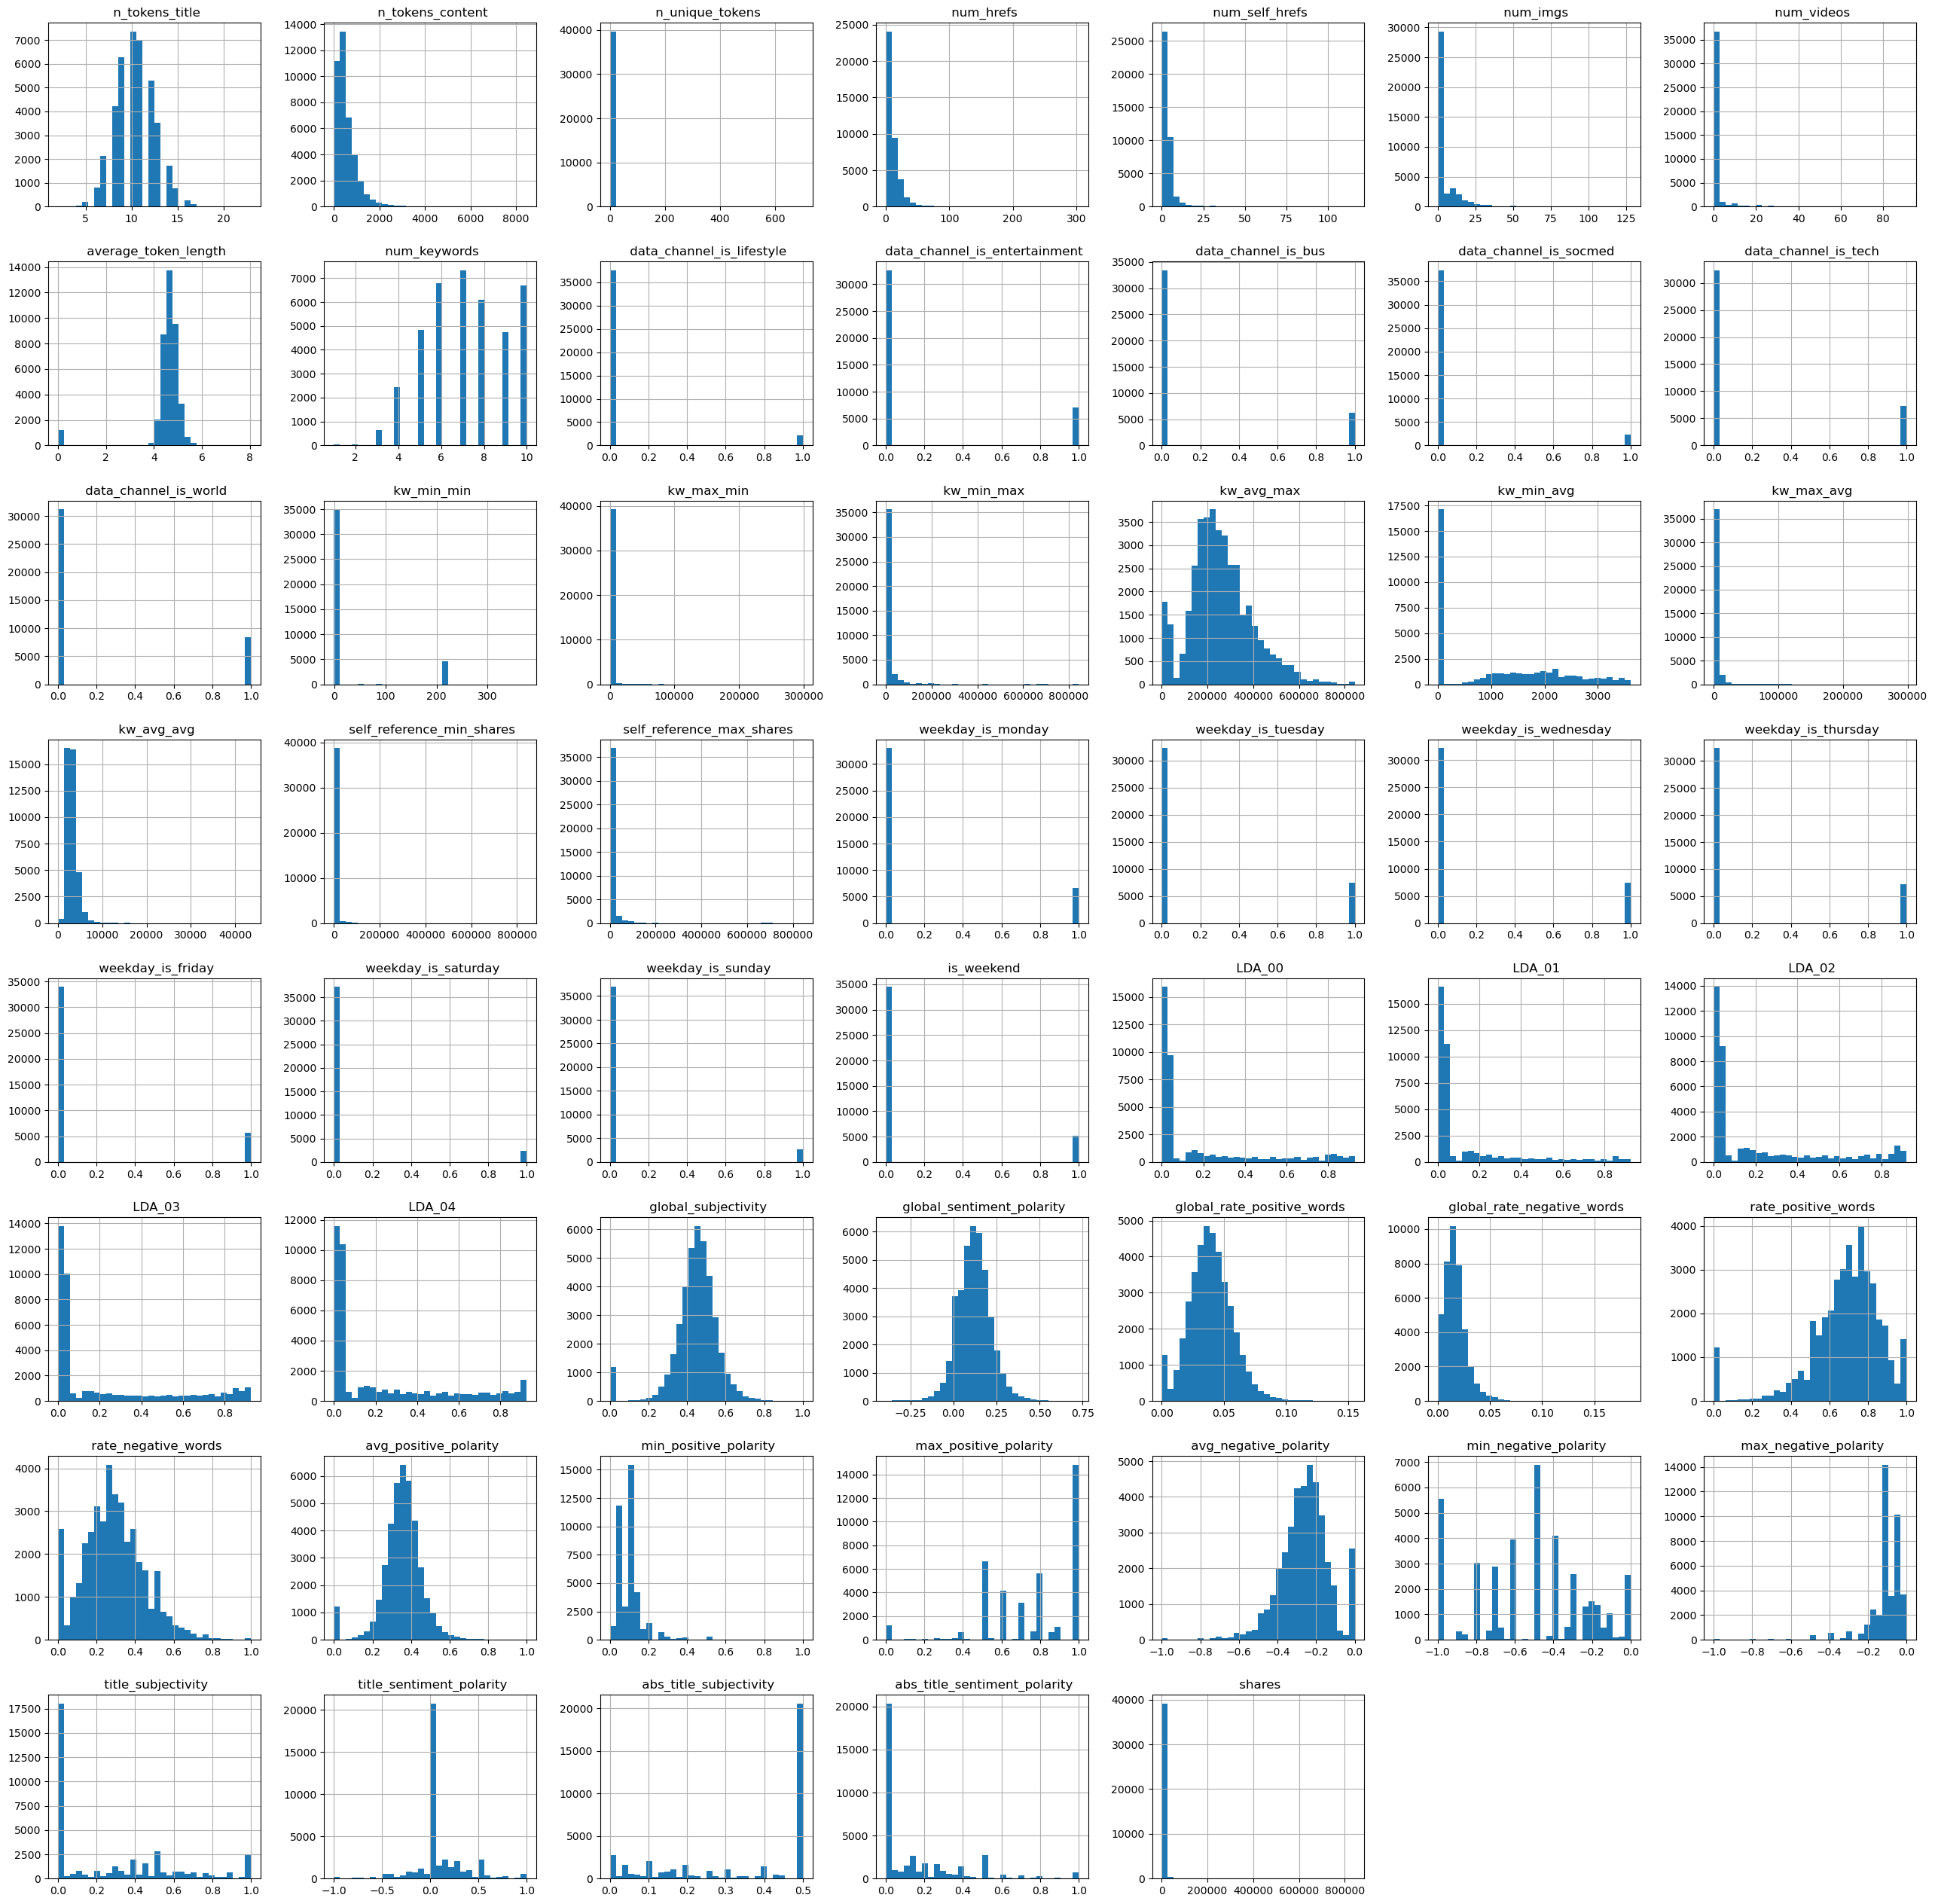

In [36]:
# Histogram of frequency distribution of features
df.hist(bins=32,figsize=(32,32)) 

In [37]:
# Show correlation coefficients between the different variables
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df.corr())

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,data_channel_is_entertainment,data_channel_is_bus,data_channel_is_socmed,data_channel_is_tech,data_channel_is_world,kw_min_min,kw_max_min,kw_min_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,weekday_is_monday,weekday_is_tuesday,weekday_is_wednesday,weekday_is_thursday,weekday_is_friday,weekday_is_saturday,weekday_is_sunday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
n_tokens_title,1.000000,0.018160,-0.005318,-0.053496,-0.014856,-0.008858,0.051460,-0.071403,-0.006077,-0.070815,0.132791,-0.023902,-0.090394,-0.046716,0.049223,-0.110672,-0.005890,0.012926,0.115746,-0.002370,0.006918,0.004296,-0.004563,0.000128,0.004274,0.009322,0.008935,-0.015472,-0.002015,-0.015013,0.006289,-0.005996,-0.070038,0.063568,0.038365,0.042208,-0.065063,-0.056804,-0.072226,-0.064951,0.015530,-0.066589,0.034186,-0.049619,-0.025069,-0.021662,-0.017096,-0.029146,0.011425,0.077245,0.000240,-0.146954,0.040550,0.008783
n_tokens_content,0.018160,1.000000,-0.004737,0.423065,0.304682,0.342600,0.103699,0.167789,0.072845,0.037548,0.060200,-0.006105,0.033424,0.025408,0.055989,-0.054345,0.000066,-0.022786,-0.096460,-0.022286,-0.030496,-0.079624,-0.030686,0.025657,-0.002484,-0.004027,-0.016891,-0.007395,-0.015949,0.034538,0.036394,0.052024,0.026218,-0.009724,0.087266,-0.140141,0.041265,0.127879,0.021937,0.133979,0.125013,0.098960,0.101053,0.135123,-0.261493,0.415706,-0.130375,-0.450603,0.225870,0.004484,0.023358,0.007136,0.013439,0.002459
n_unique_tokens,-0.005318,-0.004737,1.000000,-0.004352,0.006620,0.018802,-0.000597,0.026407,-0.003679,-0.001653,0.011016,-0.000264,-0.000945,-0.002328,-0.005535,0.001601,-0.000552,0.000577,0.000805,0.004563,-0.002120,-0.002083,0.001036,-0.000222,-0.002142,0.010538,-0.002224,-0.002248,-0.001398,-0.002563,-0.001803,-0.003186,-0.002213,-0.000827,-0.006855,-0.003689,-0.004260,-0.000180,0.000523,0.000014,-0.000877,-0.000667,-0.001657,-0.000487,0.009193,-0.009054,0.001453,0.009902,-0.007315,-0.004678,-0.002333,-0.009242,-0.004217,0.000806
num_hrefs,-0.053496,0.423065,-0.004352,1.000000,0.396452,0.342633,0.114518,0.222588,0.125890,0.052906,-0.007968,-0.058360,0.050470,-0.061734,-0.031567,-0.043263,0.012844,-0.020150,-0.019269,0.058920,0.069692,0.121419,-0.004804,0.080394,-0.005759,-0.010691,-0.032437,-0.012776,-0.001306,0.054661,0.044220,0.072279,-0.020100,-0.053803,-0.012531,0.123786,-0.054977,0.203464,0.086859,0.056428,0.032515,0.101663,0.059817,0.188236,-0.082168,0.286733,-0.152146,-0.263576,0.054948,0.043950,0.039041,0.009443,0.056525,0.045404
num_self_hrefs,-0.014856,0.304682,0.006620,0.396452,1.000000,0.238586,0.077458,0.126879,0.099578,-0.047668,0.024594,-0.055104,0.092126,0.166668,-0.118837,-0.012896,-0.001233,-0.025904,-0.064747,0.039239,-0.013629,-0.015615,-0.031229,0.130187,0.012129,0.001210,-0.020353,-0.014457,-0.021631,0.044341,0.021455,0.047798,-0.021692,-0.004631,-0.085045,-0.028775,0.135441,0.115285,0.090070,0.121140,0.011433,0.142088,-0.010187,0.098062,-0.072648,0.189922,-0.058222,-0.122071,0.039153,-0.011239,0.026224,0.008961,-0.006709,-0.001900
num_imgs,-0.008858,0.342600,0.018802,0.342633,0.238586,1.000000,-0.067336,0.033924,0.088432,0.010260,0.099327,-0.142542,-0.007626,-0.006292,-0.106480,-0.043840,0.001894,-0.000528,0.002217,0.081029,0.064374,0.145236,0.007142,0.035067,-0.005249,-0.003767,-0.024674,-0.005824,-0.007537,0.028970,0.043306,0.053242,-0.150439,0.050080,-0.094515,0.208924,-0.022780,0.080468,0.021082,-0.041582,0.024772,-0.021734,0.040

Text(0.5, 1.0, 'data_channel_is_entertainment')

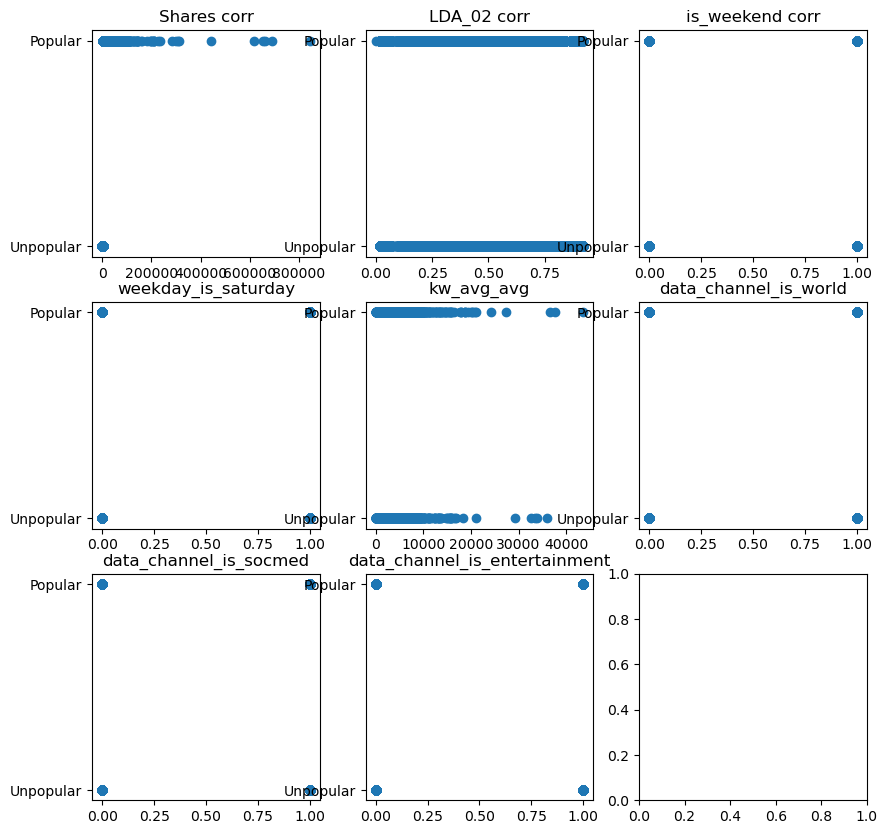

In [38]:
# Plot interesting correlations in scatter (features where the correlation with popularity is > |0.1|)
fig1, ax = plt.subplots(3,3, figsize=(10, 10))
ax[0,0].scatter(df[' shares'],df['popularity'])
ax[0, 0].set_title("Shares corr")
ax[0,1].scatter(df[' LDA_02'],df['popularity'])
ax[0, 1].set_title("LDA_02 corr")
ax[0,2].scatter(df[' is_weekend'],df['popularity'])
ax[0, 2].set_title("is_weekend corr")
ax[1,0].scatter(df[' weekday_is_saturday'],df['popularity'])
ax[1,0].set_title("weekday_is_saturday")
ax[1,1].scatter(df[' kw_avg_avg'],df['popularity'])
ax[1, 1].set_title("kw_avg_avg")
ax[1,2].scatter(df[' data_channel_is_world'],df['popularity'])
ax[1, 2].set_title("data_channel_is_world")
ax[2,0].scatter(df[' data_channel_is_socmed'],df['popularity'])
ax[2,0].set_title("data_channel_is_socmed")
ax[2,1].scatter(df[' data_channel_is_entertainment'],df['popularity'])
ax[2, 1].set_title("data_channel_is_entertainment")

# Creating and trying different models

In [39]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [40]:
# Function that handles printing of scores. Used in all models. 
def print_scores(grid):
    '''
    Prints out cross-validation accuracy, selected parameters, training set score and test set score.
    Makes a classification report. 
    
    Args:
        grid : sklearn.model_selection._search.GridSearchCV
    Returns: 
        Nothing
    '''
    # Report the best cross-validation accuracy and parameters
    print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    # Report the training set and test set scores
    print('Training set score: {:.4f}'.format(grid.score(X_train,y_train)))
    print('Test set score: {:.4f}'.format(grid.score(X_test,y_test)))
    y_pred = grid.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    
# Function that graphs the effect of training set size on accuracy
def training_size_graph(df, pipe_or_classifier):
    
    # The different amount of training/test sizes
    training_sizes = [100,500,1000,10000,20000,df.shape[0]]
    
    train_accuracies = []
    test_accuracies = []
    # Iterate over the training_sizes, fit a model, and get accuracy scores
    for training_size in training_sizes:
        
        # Randomly samples the df
        sampled_df = df.sample(n = training_size)
        
        # Split into train and val
        X = sampled_df.drop([' shares','popularity'],axis = 1)
        y = sampled_df['popularity']
        X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X,y)
        
        # Use grid & fit
        pipe_or_classifier.fit(X_train_g, y_train_g)
        
        # Get train&test accuracy score
        train_accuracies.append(pipe_or_classifier.score(X_train_g,y_train_g))
        test_accuracies.append(pipe_or_classifier.score(X_test_g,y_test_g))
        
    # Plot the accuracies
    fig1, ax = plt.subplots(1,1)
    ax.plot(training_sizes, train_accuracies, training_sizes, test_accuracies)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Amount of Samples')
    ax.legend(['Train Accuracies', 'Test Accuracies'])
    ax.set_title('Effects of diminishing training set size on accuracy')

    
# Function that graphs regularization strength on generalization
def hyperparam_graph(grid, param_grid, param_grid_key):
    
    # Plot the accuracies
    fig1, ax = plt.subplots(1,1)
    ax.plot(param_grid[param_grid_key],grid.cv_results_['mean_test_score'])
    ax.set_ylabel('Accuracy')
    ax.set_xlabel(param_grid_key)
    ax.set_title('Regularization strength on generalization')

## LogisticRegression Classifier

In [41]:
# LogisticRegression Classifier
def logistic_regression(df,X_train,y_train, X_test,y_test):
    ''' 
    Logistic Regression using MinMaxScaler, GridSearchCV, and cross-validation. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and a classification report.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    # Grid Search and Pipeline
    param_grid = {'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 125, 150, 175 , 200]}

    # Pipeline with a using Min Max Scaler and Logistic Regression 
    pipe = Pipeline([("scaler", MinMaxScaler()), ("lr", LogisticRegression(max_iter = 10000))]) 
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    # Print the results
    print_scores(grid)
    
    # Effects of diminishing training set size on accuracy graph
    training_size_graph(df,pipe)
    
    # Regularization strength effect on generalization graph
    hyperparam_graph(grid,param_grid, 'lr__C')

Best cross-validation accuracy: 0.65
Best parameters: {'lr__C': 150}
Training set score: 0.6481
Test set score: 0.6609
              precision    recall  f1-score   support

     Popular       0.67      0.63      0.65      4906
   Unpopular       0.66      0.69      0.67      5005

    accuracy                           0.66      9911
   macro avg       0.66      0.66      0.66      9911
weighted avg       0.66      0.66      0.66      9911



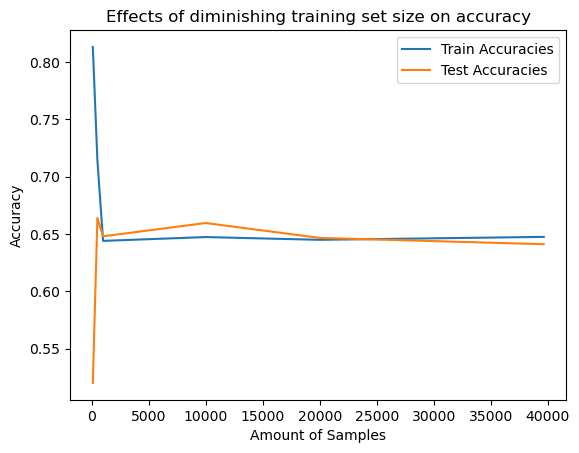

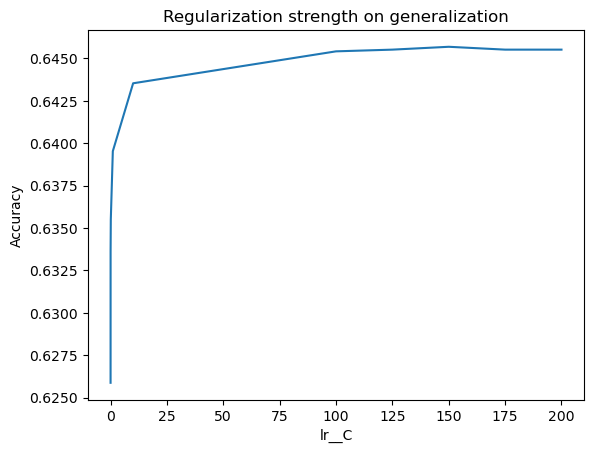

In [42]:
logistic_regression(df,X_train,y_train, X_test,y_test)

## SVC Classifier

In [43]:
# SVC Classifier
def linear_svc_classifier(df, X_train,y_train, X_test,y_test):
    ''' 
    Linear SVC classifier using MinMaxScaler, GridSearchCV, and cross-validation. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    # If the C is increased over 10, it takes a very long time to train. 
    # A sacrifice in order to improve training time has been made, therefore, we leave it at a maximum of 10. 
    param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10]} 
    
    # Pipeline with a using MinMaxScaler and Linear SVC Classifier 
    pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", LinearSVC(max_iter = 10000))]) 
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    # Print the results
    print_scores(grid)
    
    # Effects of diminishing training set size on accuracy graph
    training_size_graph(df,pipe)
    
    # Regularization strength effect on generalization graph
    hyperparam_graph(grid,param_grid, 'svm__C')


Best cross-validation accuracy: 0.64
Best parameters: {'svm__C': 10}
Training set score: 0.6468
Test set score: 0.6589
              precision    recall  f1-score   support

     Popular       0.66      0.63      0.65      4906
   Unpopular       0.66      0.68      0.67      5005

    accuracy                           0.66      9911
   macro avg       0.66      0.66      0.66      9911
weighted avg       0.66      0.66      0.66      9911



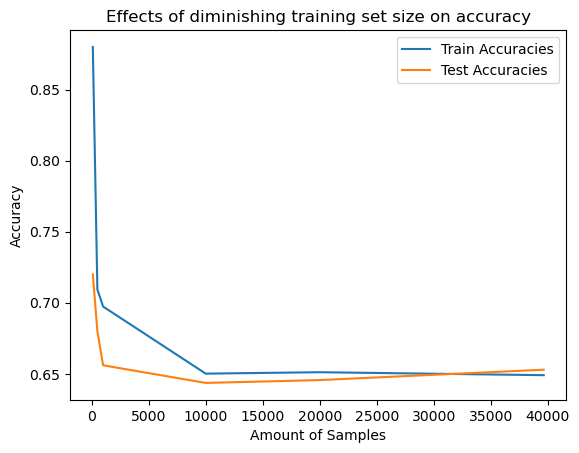

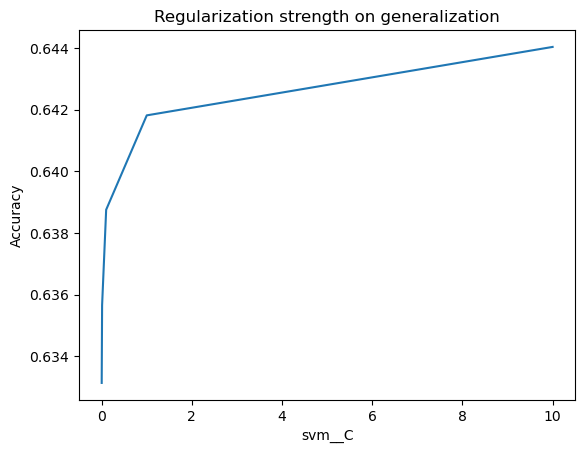

In [44]:
linear_svc_classifier(df, X_train,y_train, X_test,y_test)

## KNN Classifier

In [45]:
# KNN Classifier
def k_neighbors_classifier(df, X_train,y_train, X_test,y_test):
    ''' K Neighbors Classifier using MinMaxScaler, GridSearchCV, and cross-validation. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    
    # param_grid with 1 to 25 K neighbors
    param_grid = {'knn__n_neighbors': list(range(1,25))}
    
    # Pipeline with a using MinMaxScaler and Linear SVC Classifier 
    pipe = Pipeline([("scaler", MinMaxScaler()), ("knn", KNeighborsClassifier())])
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    # Print the results
    print_scores(grid)
    
    # Effects of diminishing training set size on accuracy graph
    training_size_graph(df,pipe)
    

Best cross-validation accuracy: 0.62
Best parameters: {'knn__n_neighbors': 24}
Training set score: 0.6600
Test set score: 0.6350
              precision    recall  f1-score   support

     Popular       0.63      0.62      0.63      4906
   Unpopular       0.64      0.65      0.64      5005

    accuracy                           0.63      9911
   macro avg       0.63      0.63      0.63      9911
weighted avg       0.63      0.63      0.63      9911



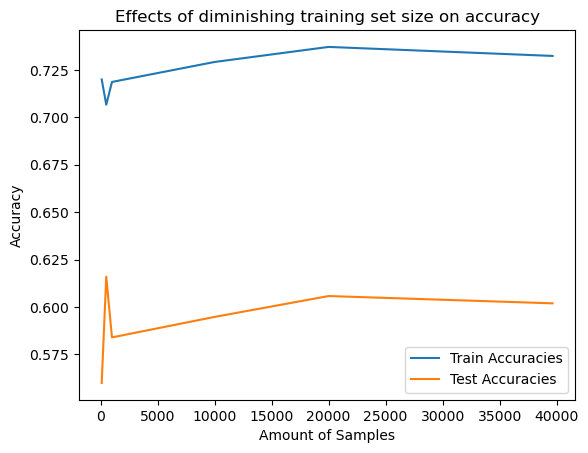

In [46]:
k_neighbors_classifier(df, X_train,y_train, X_test,y_test)

## DecisionTree Classifier

In [47]:
# DecisionTree Classifier
def decision_tree(df, X_train,y_train, X_test,y_test):
    ''' 
    Decision Tree Classifier using MinMaxScaler, GridSearchCV, and cross-validation. 
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''
    # Grid Search
    param_grid = {'max_depth': [2,4,6,8,10],'max_features':[0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7]}
    tree = DecisionTreeClassifier()
    grid = GridSearchCV(tree, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    # Print the results
    print_scores(grid)
    
    # Effects of diminishing training set size on accuracy graph
    training_size_graph(df,tree)

Best cross-validation accuracy: 0.63
Best parameters: {'max_depth': 6, 'max_features': 0.6}
Training set score: 0.6479
Test set score: 0.6437
              precision    recall  f1-score   support

     Popular       0.65      0.61      0.63      4906
   Unpopular       0.64      0.68      0.66      5005

    accuracy                           0.64      9911
   macro avg       0.64      0.64      0.64      9911
weighted avg       0.64      0.64      0.64      9911



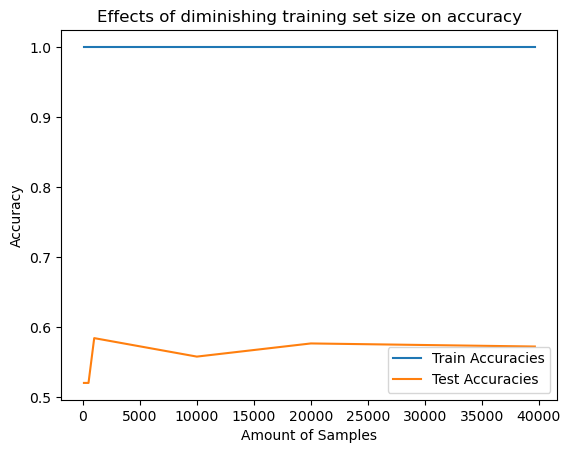

In [48]:
decision_tree(df, X_train,y_train, X_test,y_test)

## RandomForest Classifier

In [49]:
# RandomForest Classifier
def random_forest(df, X_train,y_train, X_test,y_test):
    ''' 
    Random Forest Classifier using MinMaxScaler, GridSearchCV, and cross-validation.
    
    Prints the cross-validation accuracy, the selected best parameters, the scaled training&test scores, 
    and the classification report.
    
    Args:
        X_train : pandas.core.frame.DataFrame [The arguments that you would like to train the model on]
        y_train : pandas.core.frame.DataFrame [The target that you would like to train the model on]
        X_test : pandas.core.frame.DataFrame [The arguments that you would like to test the model on]
        y_test : pandas.core.frame.DataFrame [The target that you would like to test the model on]
    
    Returns:
        Does not return anything.  
    '''

    # Grid Search parameters 
    param_grid = {'max_depth': [2,4,8,10],'max_features':['auto', 'sqrt', 'log2'],'n_estimators':[100,200,300,400]}
    
    # Using all processor cores on Random Forest for faster training.
    rfc = RandomForestClassifier(n_jobs=-1)
    grid = GridSearchCV(rfc, param_grid=param_grid, cv=5)
    grid.fit(X_train, y_train)
    
    # Print the results
    print_scores(grid)
    
    # Effects of diminishing training set size on accuracy graph
    training_size_graph(df,rfc)

Best cross-validation accuracy: 0.66
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Training set score: 0.7656
Test set score: 0.6737
              precision    recall  f1-score   support

     Popular       0.67      0.66      0.67      4906
   Unpopular       0.67      0.68      0.68      5005

    accuracy                           0.67      9911
   macro avg       0.67      0.67      0.67      9911
weighted avg       0.67      0.67      0.67      9911



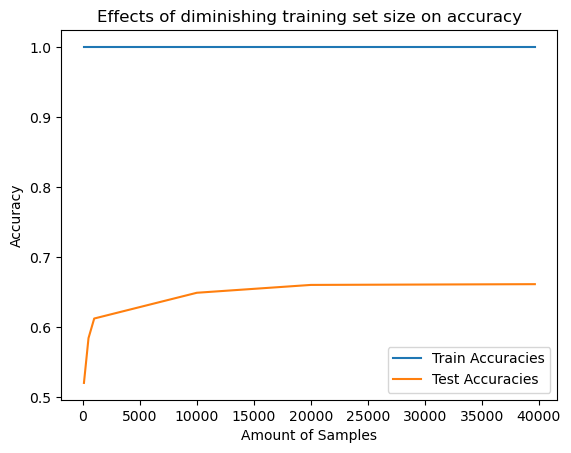

In [50]:
filterwarnings(action='ignore', category=FutureWarning)

random_forest(df, X_train,y_train, X_test,y_test)

# Unsupervised Learning

In [51]:
# scaling feature values
scaler = MinMaxScaler().fit(X) 
X_scaled = scaler.transform(X)

Text(0, 0.5, 'SSE')

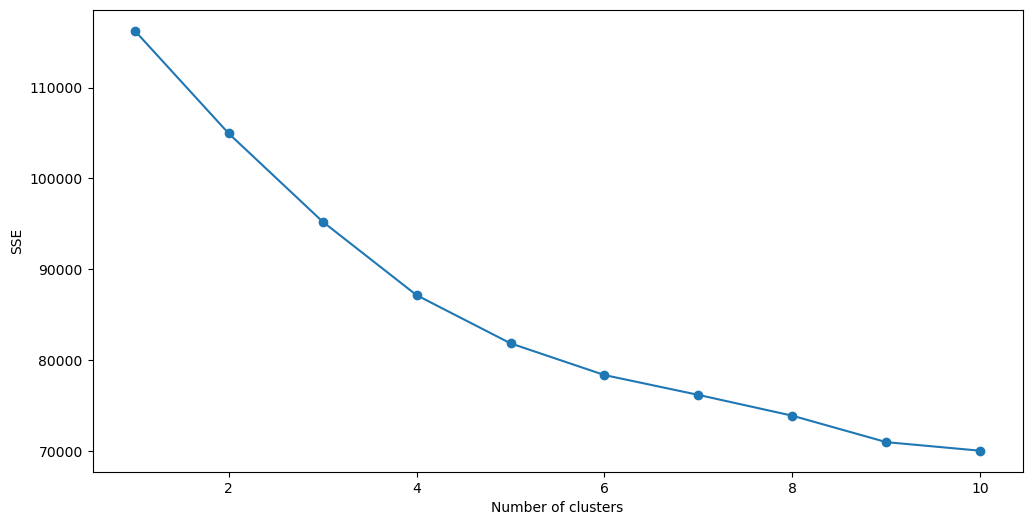

In [52]:
# fit k-means algorithms 
SSE = []
for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++',random_state= 5)
    kmeans.fit(X_scaled)
    SSE.append(kmeans.inertia_)

# plot results
frame = pd.DataFrame({'Cluster':range(1,11), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')


In [53]:
# define a function to creat silhouette results

def silhouette_plot(X, cluster_labels, ax=None):
    silhouette_scores = silhouette_samples(X, cluster_labels)
    if ax is None:
        ax = plt.gca()
    y_lower = 10
    inliers = cluster_labels != -1
    X = X[inliers]
    cluster_labels = cluster_labels[inliers]
    silhouette_scores = silhouette_scores[inliers]
    labels = np.unique(cluster_labels)
#     cm = plt.cm.Vega10 if len(labels) <= 10 else plt.cm.Vega20
    cm = plt.cm.tab10 if len(labels) <= 10 else plt.cm.tab20

    for i in labels:
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm(i)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

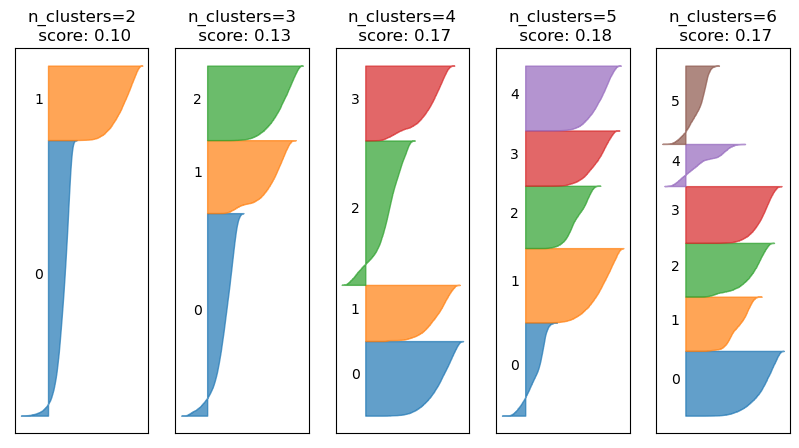

In [54]:
# show silhouette results 
fig, axes = plt.subplots(1, 5, subplot_kw={'xticks': (), 'yticks':()}, figsize=(10, 5))
for ax, n_clusters in zip(axes, [2,3,4,5,6]):
    km = KMeans(n_clusters=n_clusters, init='k-means++',random_state= 5)
    km.fit(X_scaled)
    silhouette_plot(X_scaled, km.labels_, ax=ax)
    ax.set_title("n_clusters={}\n score: {:.2f}".format(n_clusters, silhouette_score(X_scaled, km.labels_)))

In [55]:
k = 5  # cluster numbers
iter_num =1000   # max iters
model = KMeans(n_clusters=k, max_iter=iter_num, init='k-means++',random_state= 5)   
model.fit(X_scaled) # fit K-Means

KMeans(max_iter=1000, n_clusters=5, random_state=5)

In [56]:
cluster_counts = pd.Series(model.labels_).value_counts() # count how many members in every cluster
cluster_centers = pd.DataFrame(model.cluster_centers_) # coordinates of cluster centers
clusters = pd.concat([cluster_centers,cluster_counts], axis=1) 
clusters.columns = list(X.columns) + [u'class members']
clusters # overview of 5 clusters

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,class members
0,0.383289,0.053303,0.000764,0.044369,0.027712,0.050122,0.020492,0.545397,0.713576,1.988254e-01,...,0.104941,0.758222,0.726502,0.478977,0.881390,0.331097,0.546653,0.678037,0.192237,10557
1,0.409470,0.070490,0.000729,0.033540,0.020793,0.022199,0.006038,0.581753,0.698816,9.228729e-16,...,0.088475,0.698935,0.747755,0.439343,0.906106,0.243500,0.515092,0.722274,0.127621,8426
2,0.428666,0.071685,0.000901,0.035163,0.030150,0.049357,0.027976,0.556712,0.658322,5.481726e-16,...,0.093508,0.797694,0.705862,0.412294,0.889377,0.315796,0.532309,0.642062,0.171817,7057
3,0.394383,0.063709,0.000779,0.030777,0.024164,0.014128,0.006994,0.582976,0.609957,2.775558e-16,...,0.086631,0.768000,0.757180,0.519816,0.890802,0.249068,0.540095,0.681515,0.139082,6258
4,0.390079,0.067455,0.000758,0.030976,0.040008,0.034645,0.004914,0.569807,0.752881,6.383782e-16,...,0.099166,0.771912,0.771230,0.548738,0.897305,0.253097,0.543180,0.689376,0.136037,7346


In [57]:
data_out = pd.concat([df2_scaled, pd.Series(model.labels_, index=X.index,name='class')], axis=1) # add the class they are assigned to on each line
data_out.index.names=['id'] #add index
data_out = pd.concat([data_out,df[' shares']], axis=1) # add the target
data_out.head(5)

,n_tokens_title,n_tokens_content,n_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel_is_lifestyle,...,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares,popularity,class,shares
0,0.476190,0.025844,0.000947,0.013158,0.017241,0.007812,0.0,0.582024,0.444444,0.0,...,0.400,0.800000,0.500000,0.406250,0.000000,0.187500,0.000702,Unpopular,2,593
1,0.333333,0.030092,0.000863,0.009868,0.008621,0.007812,0.0,0.611043,0.333333,0.0,...,0.875,0.900000,0.000000,0.500000,1.000000,0.000000,0.000842,Unpopular,3,711
2,0.333333,0.024900,0.000820,0.009868,0.008621,0.007812,0.0,0.546334,0.555556,0.0,...,0.200,0.866667,0.000000,0.500000,1.000000,0.000000,0.001778,Popular,3,1500
3,0.333333,0.062662,0.000719,0.029605,0.000000,0.007812,0.0,0.547768,0.666667,0.0,...,0.400,0.833333,0.000000,0.500000,1.000000,0.000000,0.001422,Unpopular,2,1200
4,0.523810,0.126505,0.000593,0.062500,0.163793,0.156250,0.0,0.582331,0.666667,0.0,...,0.500,0.950000,0.454545,0.568182,0.090909,0.136364,0.000598,Unpopular,4,505


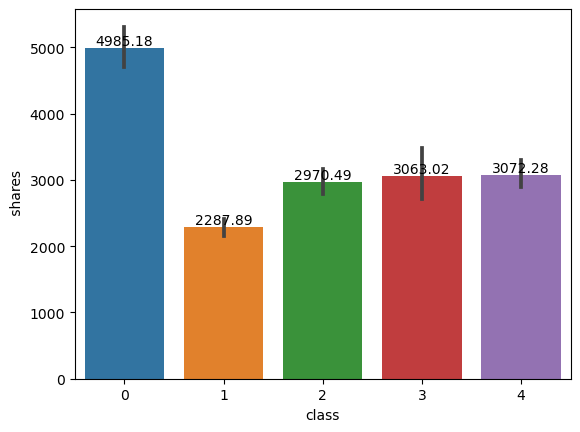

In [58]:
p = sns.barplot(data_out['class'], df[" shares"]) # Comparing shares of 5 class
for container in p.containers: #show the numbers
    p.bar_label(container)

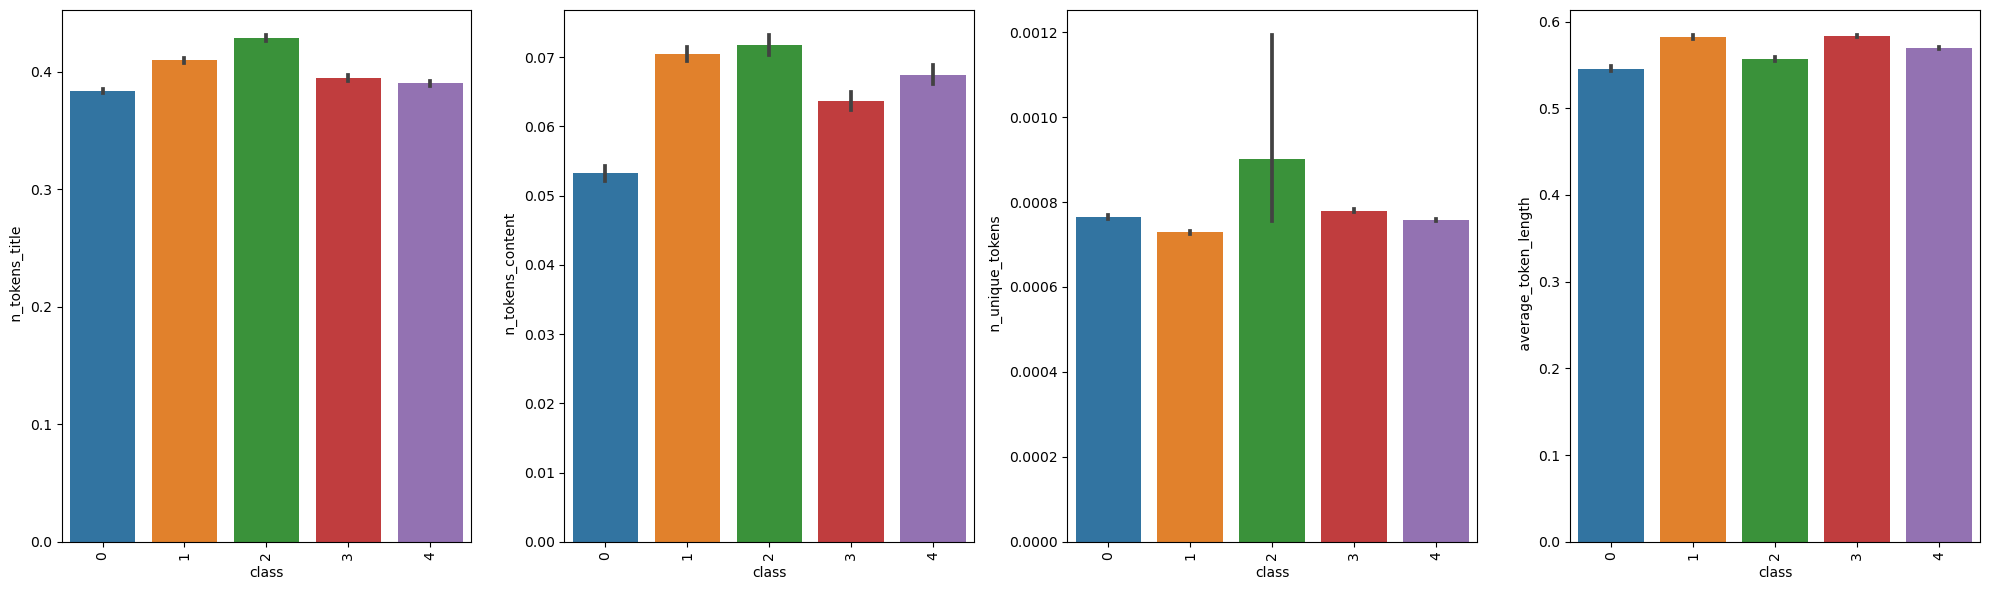

In [59]:
show_barplots(data_out,word_features,'class') # Comparing word features of 5 class

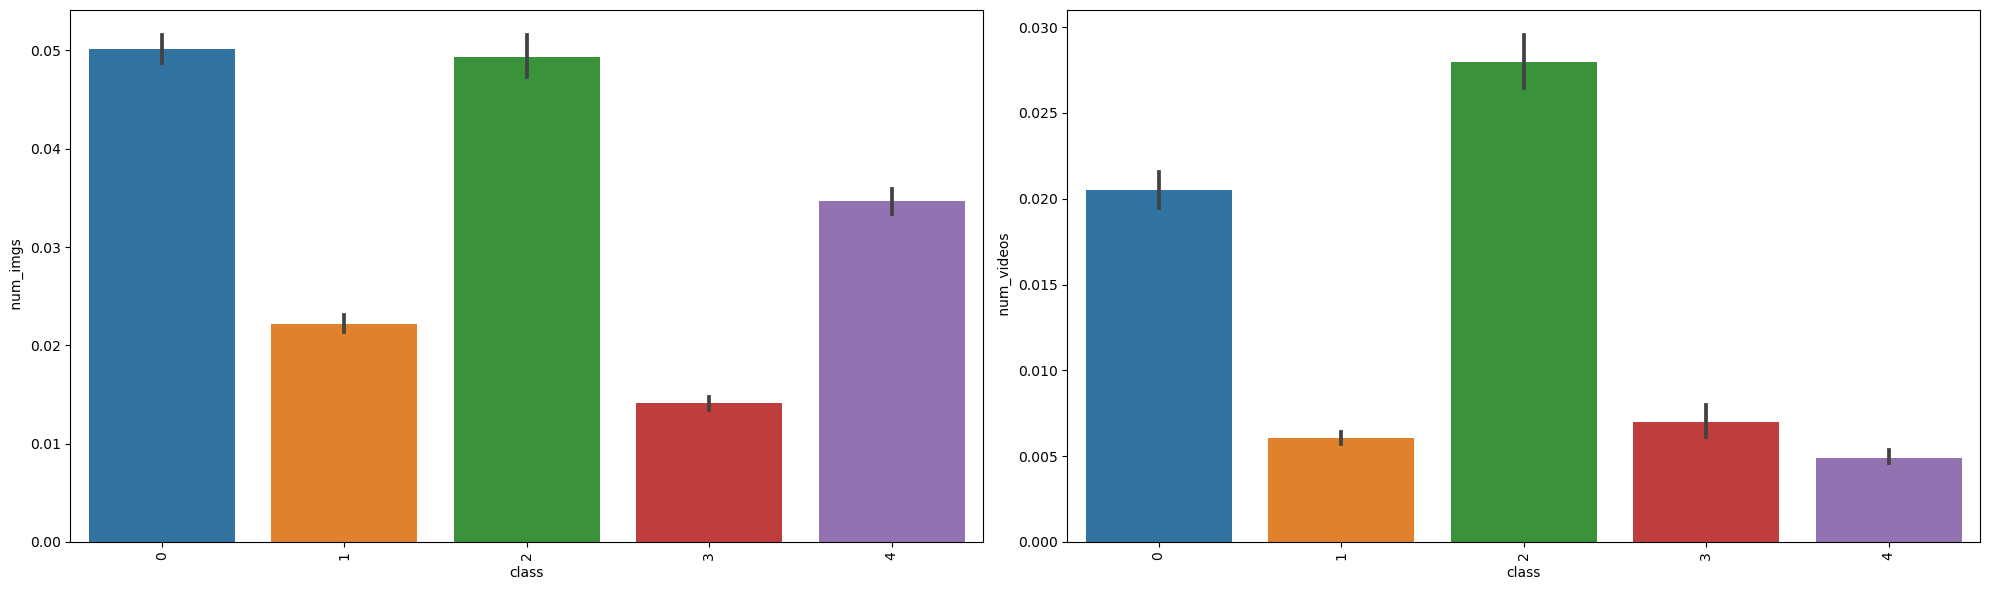

In [60]:
show_barplots(data_out,media_features,'class') # Comparing media features of 5 class

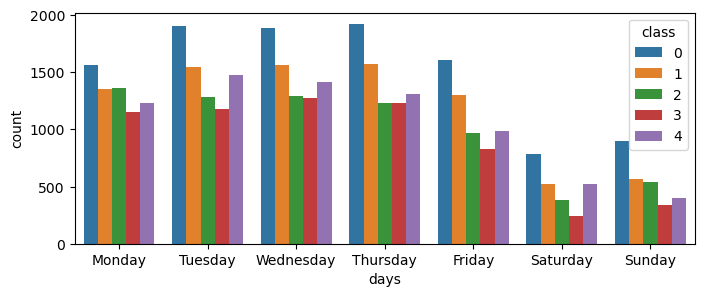

In [61]:
# Comparing published days features of 5 class
plt.figure(figsize=(8,3))
sns.countplot(df2_scaled.days,hue=data_out['class'])
plt.show()

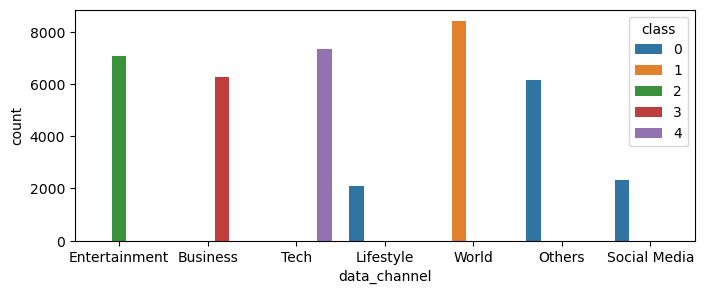

In [62]:
# Comparing data channel features of 5 class
plt.figure(figsize=(8,3))
sns.countplot(df2_scaled.data_channel,hue=data_out['class'])
plt.show()

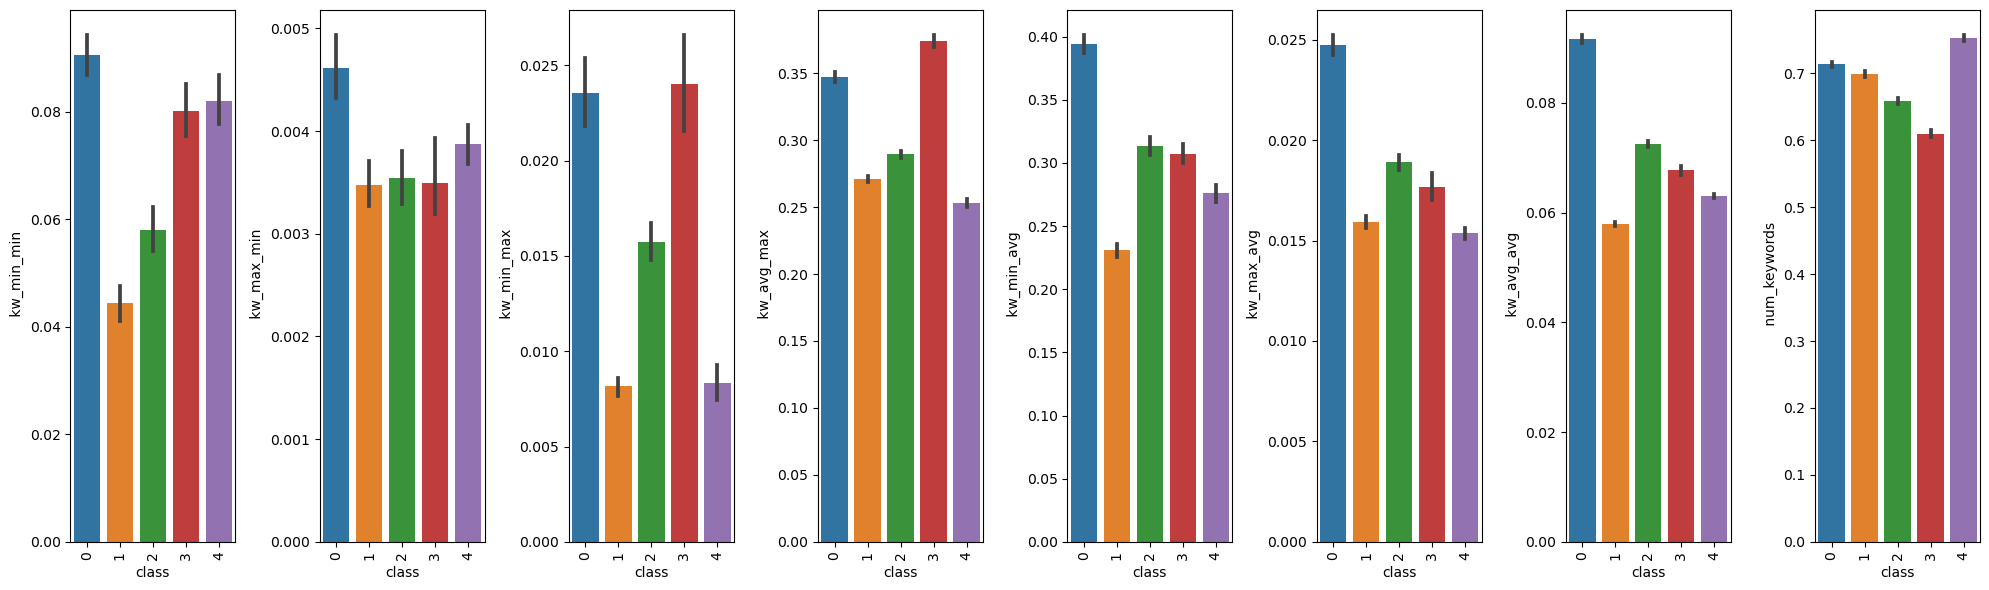

In [63]:
show_barplots(data_out,keyword_features,'class') # Comparing keyword features of 5 class

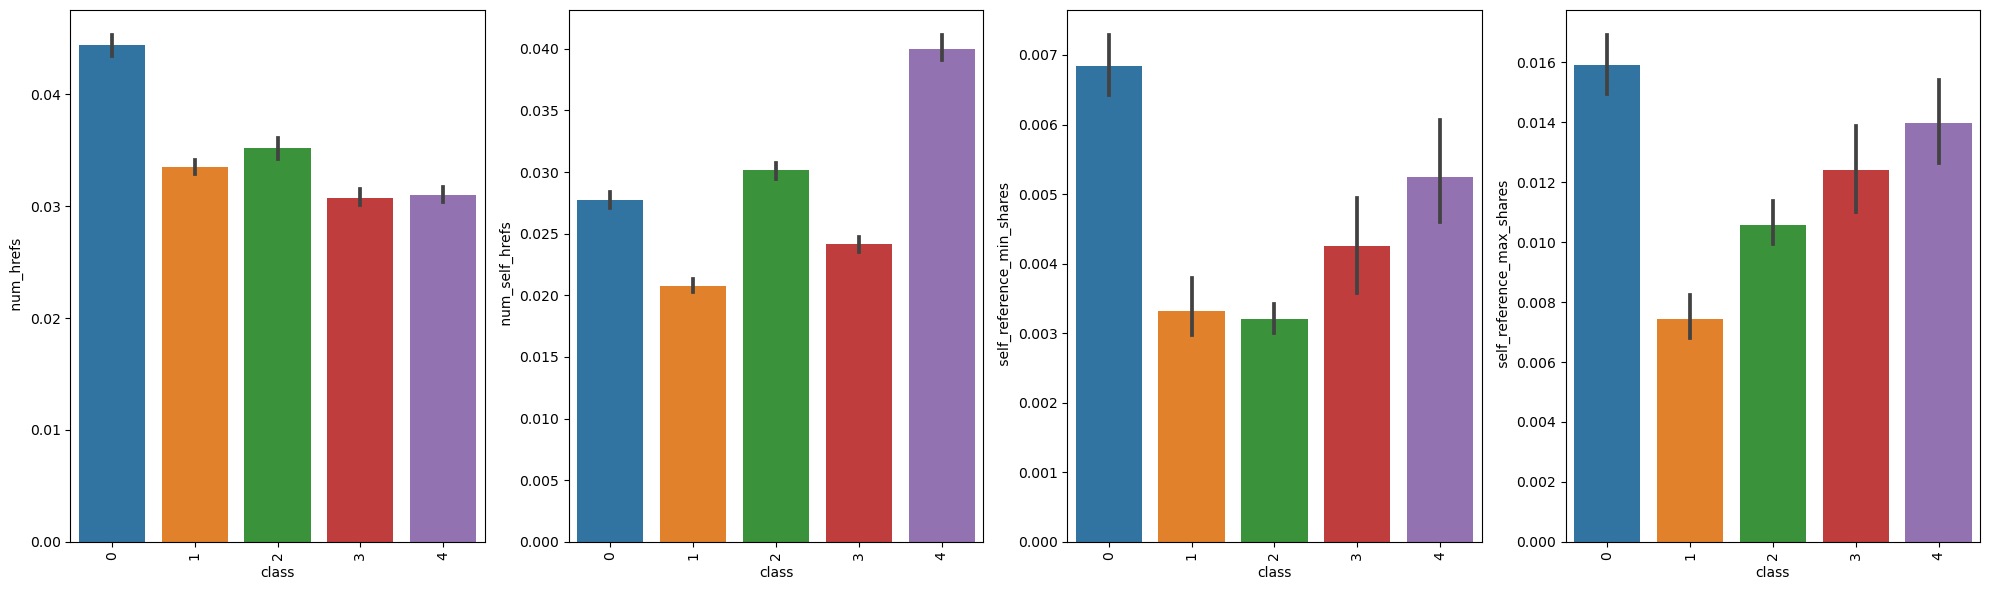

In [64]:
show_barplots(data_out,reference_features,'class') # Comparing reference features of 5 class

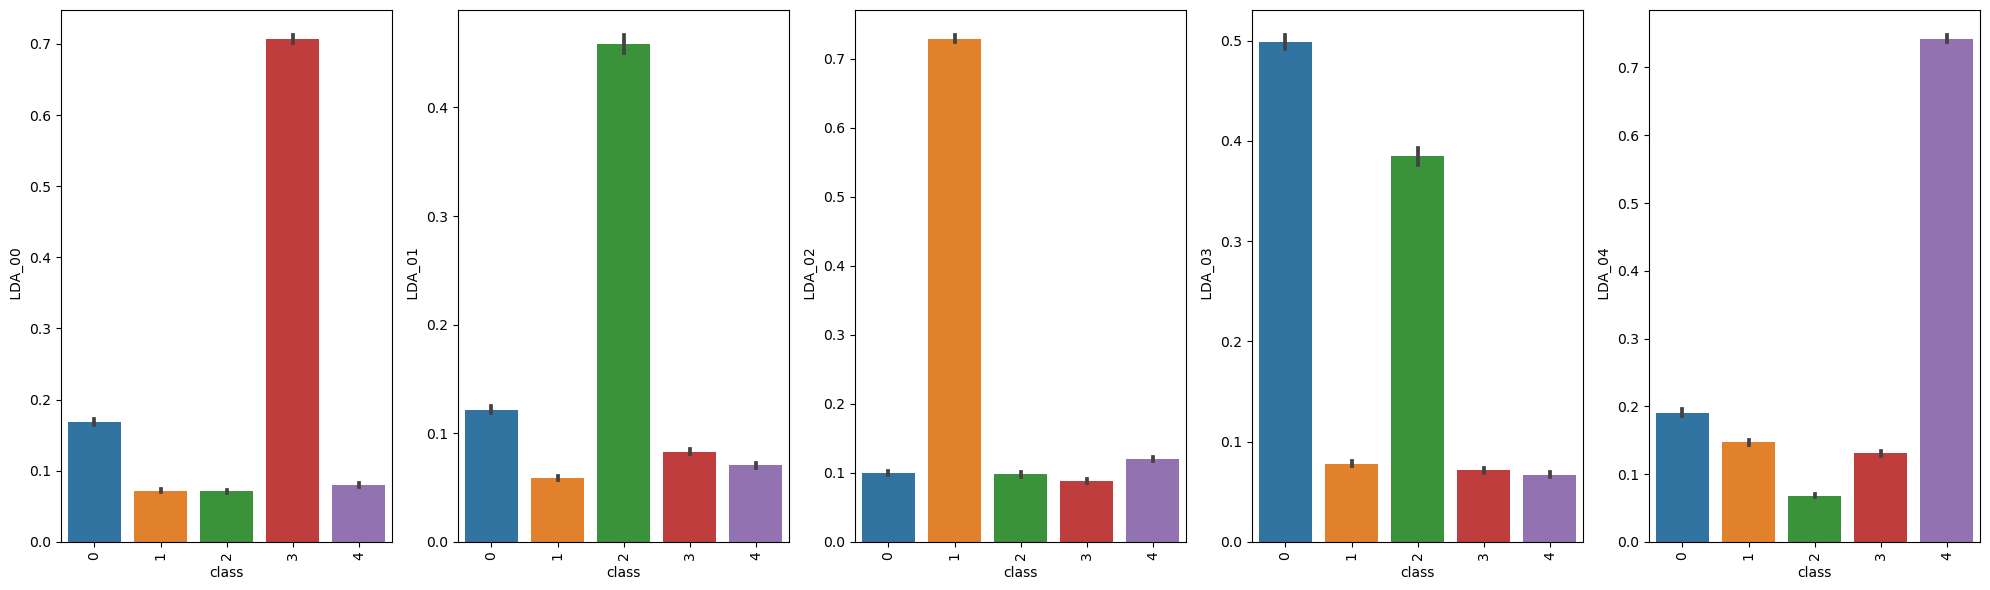

In [65]:
show_barplots(data_out,topic_features,'class') # Comparing topic features of 5 class

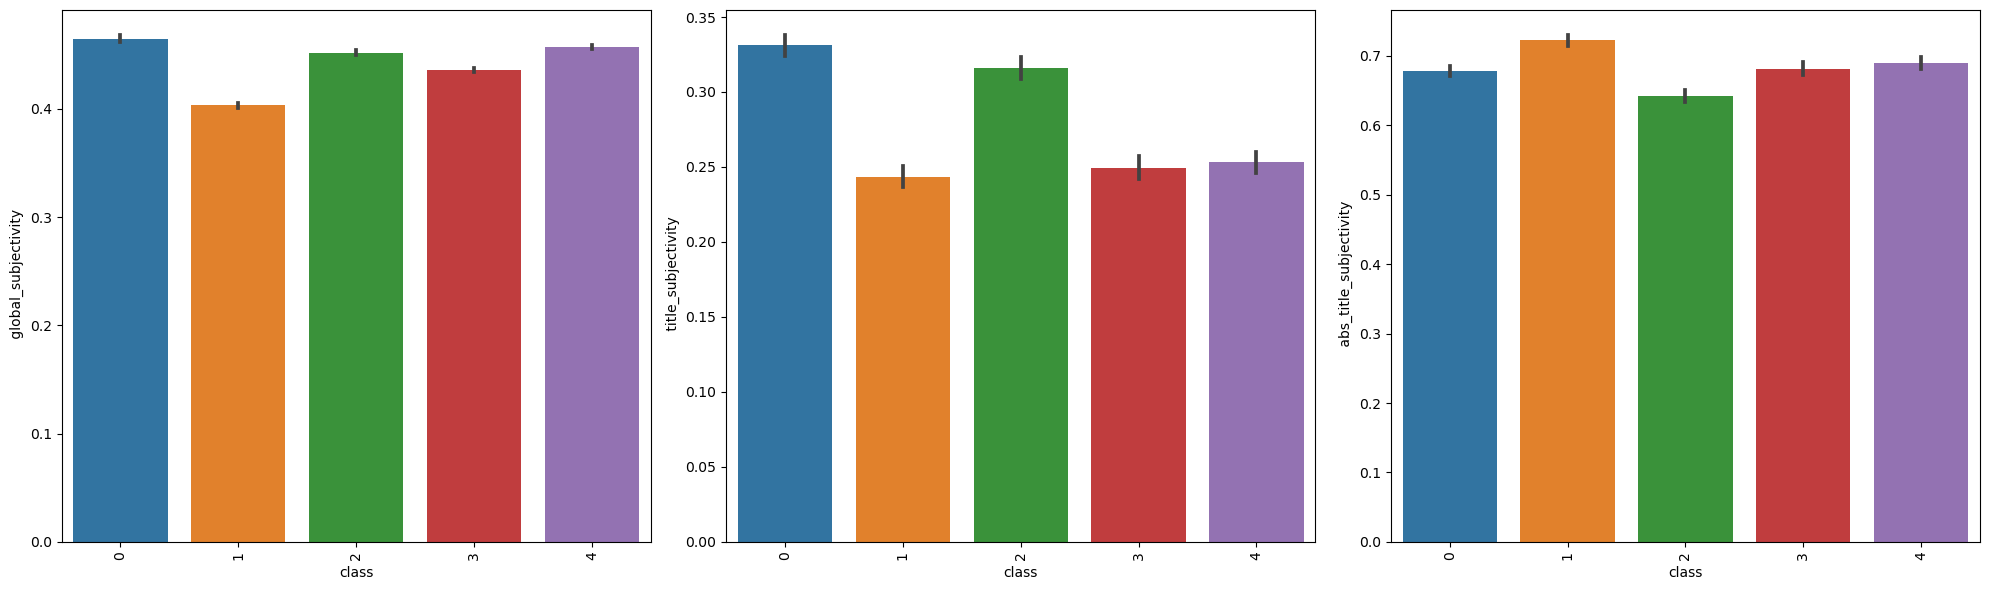

In [66]:
show_barplots(data_out,subjectivity_features,'class') # Comparing subjectivity features of 5 class

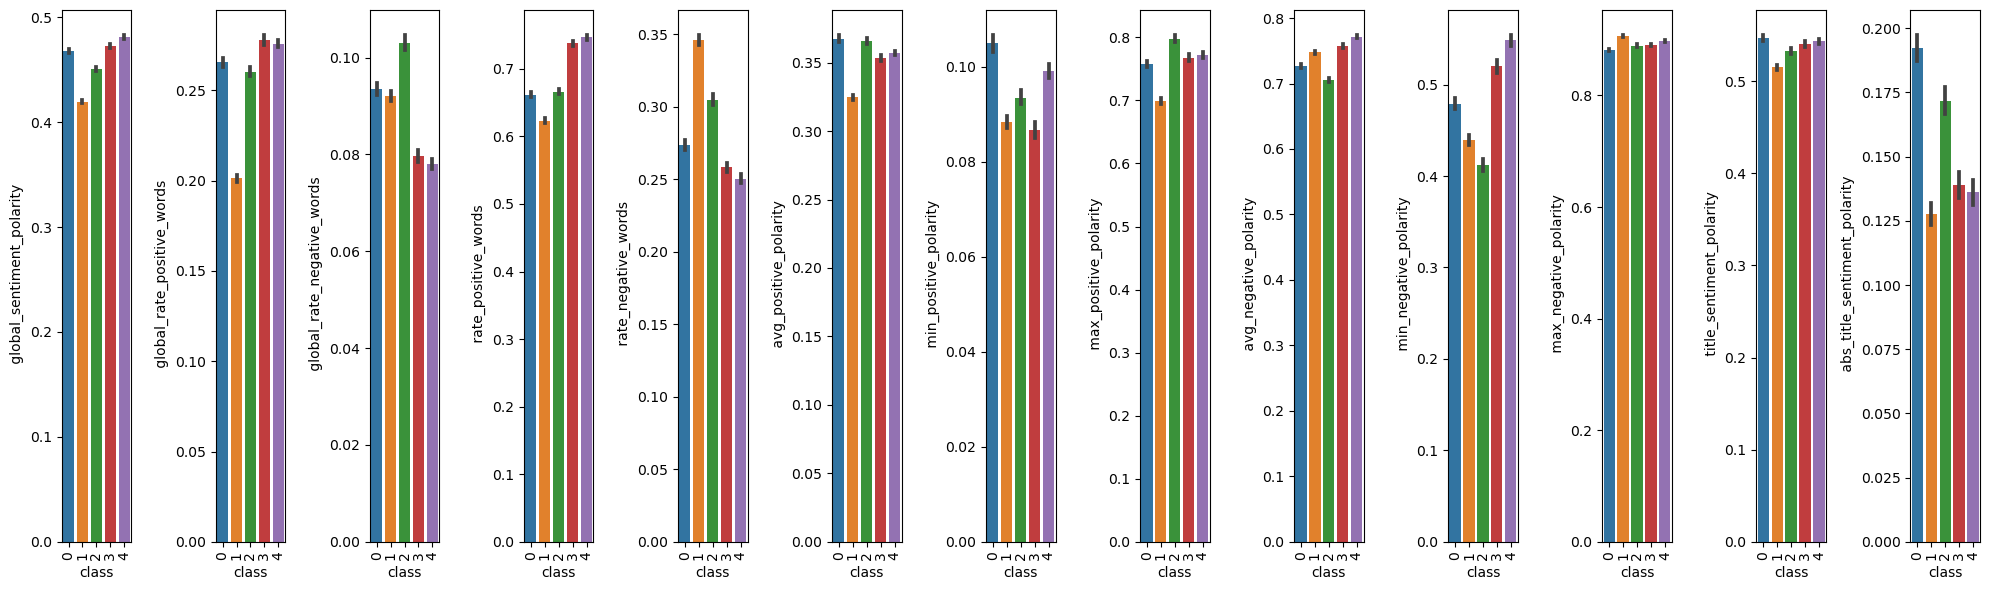

In [67]:
show_barplots(data_out,sentiment_features,'class') # Comparing sentiment features of 5 class